In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             classification_report, matthews_corrcoef)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('synthetic_coffee_health_10000.csv')

print("="*60)
print("ОГЛЯД ДАТАСЕТУ")
print("="*60)
print(f"\nРозмір датасету: {df.shape}")
print(f"\nПерші 5 рядків:")
print(df.head())


ОГЛЯД ДАТАСЕТУ

Розмір датасету: (10000, 16)

Перші 5 рядків:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consumpti

In [3]:
print(f"\nІнформація про колонки:")
print(df.info())


Інформація про колонки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14

In [4]:
print(f"\nСтатистика числових змінних:")
print(df.describe())


Статистика числових змінних:
                ID           Age  Coffee_Intake   Caffeine_mg   Sleep_Hours  \
count  10000.00000  10000.000000   10000.000000  10000.000000  10000.000000   
mean    5000.50000     34.949100       2.509230    238.411010      6.636220   
std     2886.89568     11.160939       1.450248    137.748815      1.222055   
min        1.00000     18.000000       0.000000      0.000000      3.000000   
25%     2500.75000     26.000000       1.500000    138.750000      5.800000   
50%     5000.50000     34.000000       2.500000    235.400000      6.600000   
75%     7500.25000     43.000000       3.500000    332.025000      7.500000   
max    10000.00000     80.000000       8.200000    780.300000     10.000000   

                BMI    Heart_Rate  Physical_Activity_Hours      Smoking  \
count  10000.000000  10000.000000              10000.00000  10000.00000   
mean      23.986860     70.617800                  7.48704      0.20040   
std        3.906411      9.822951

In [5]:
print(f"\nПропущені значення:")
print(df.isnull().sum())


Пропущені значення:
ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64


In [6]:
print(f"\nВидаляємо {df['Health_Issues'].isna().sum()} рядків без мітки цільової змінної...")
df = df.dropna(subset=['Health_Issues'])
print(f"Залишилось рядків після видалення: {len(df)}")


Видаляємо 5941 рядків без мітки цільової змінної...
Залишилось рядків після видалення: 4059


In [7]:
print("\n" + "="*60)
print("ВИДАЛЕННЯ КОЛОНКИ ID")
print("="*60)

if 'ID' in df.columns:
    df = df.drop('ID', axis=1)
    print("✓ Колонка 'ID' успішно видалена")
else:
    print("✓ Колонка 'ID' відсутня в датасеті")


ВИДАЛЕННЯ КОЛОНКИ ID
✓ Колонка 'ID' успішно видалена


In [8]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("РОЗДІЛЕННЯ ДАНИХ")
print("="*60)

X = df.drop('Health_Issues', axis=1)
y = df['Health_Issues']

print(f"Розмір ознак (X): {X.shape}")
print(f"Розмір цільової змінної (y): {y.shape}")


РОЗДІЛЕННЯ ДАНИХ
Розмір ознак (X): (4059, 14)
Розмір цільової змінної (y): (4059,)


In [9]:
print("\n" + "="*60)
print("КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ")
print("="*60)

# Визначення категоріальних колонок
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                    'Occupation', 'Smoking', 'Alcohol_Consumption']
categorical_cols = [col for col in categorical_cols if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

print(f"\nКатегоріальні колонки ({len(categorical_cols)}): {categorical_cols}")
print(f"Числові колонки ({len(numerical_cols)}): {numerical_cols}")

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"\n✓ Розмірність після кодування: {X_encoded.shape}")

# Label Encoding для цільової змінної
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nКласи цільової змінної:")
for i, class_name in enumerate(le_target.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {i}: {class_name} - {count} зразків ({count/len(y_encoded)*100:.2f}%)")


КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ

Категоріальні колонки (7): ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Числові колонки (7): ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']

✓ Розмірність після кодування: (4059, 39)

Класи цільової змінної:
  0: Mild - 3579 зразків (88.17%)
  1: Moderate - 463 зразків (11.41%)
  2: Severe - 17 зразків (0.42%)



 АНАЛІЗ НЕЗБАЛАНСОВАНОСТІ

Розподіл класів ДО балансування: {0: 3579, 1: 463, 2: 17}


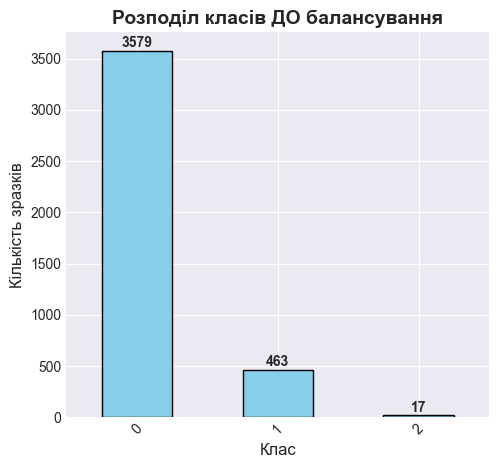

In [10]:
print("\n" + "="*60)
print(" АНАЛІЗ НЕЗБАЛАНСОВАНОСТІ")
print("="*60)

class_distribution = Counter(y_encoded)
print(f"\nРозподіл класів ДО балансування: {dict(class_distribution)}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
pd.Series(y_encoded).value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Розподіл класів ДО балансування", fontsize=14, fontweight='bold')
plt.xlabel("Клас", fontsize=12)
plt.ylabel("Кількість зразків", fontsize=12)
plt.xticks(rotation=45)
for i, v in enumerate(pd.Series(y_encoded).value_counts().sort_index()):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')


In [11]:
print(" РОЗДІЛЕННЯ НА TRAIN/TEST")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

print("\nРозподіл класів у тренувальній вибірці:")
train_dist = Counter(y_train)
for cls, count in sorted(train_dist.items()):
    print(f"  Клас {le_target.classes_[cls]}: {count} ({count/len(y_train)*100:.2f}%)")

 РОЗДІЛЕННЯ НА TRAIN/TEST

Розмір тренувальної вибірки: (3247, 39)
Розмір тестової вибірки: (812, 39)

Розподіл класів у тренувальній вибірці:
  Клас Mild: 2863 (88.17%)
  Клас Moderate: 370 (11.40%)
  Клас Severe: 14 (0.43%)


In [12]:
print("\n" + "="*60)
print("РОЗДІЛЕННЯ НА TRAIN/TEST")
print("="*60)

# ВАЖЛИВО: Розділяємо ПЕРЕД кодуванням, щоб уникнути витоку даних
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nРозмір тренувальної вибірки: {X_train_raw.shape}")
print(f"Розмір тестової вибірки: {X_test_raw.shape}")

# Кодування ОКРЕМО для train та test
print("\n⚠️ Виконуємо one-hot encoding окремо для train/test...")
X_train_encoded = pd.get_dummies(X_train_raw, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_raw, columns=categorical_cols, drop_first=True)

# Вирівнювання колонок (важливо!)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"Train shape після кодування: {X_train_encoded.shape}")
print(f"Test shape після кодування: {X_test_encoded.shape}")

print("\nРозподіл класів у тренувальній вибірці:")
train_dist = Counter(y_train)
for cls, count in sorted(train_dist.items()):
    print(f"  Клас {le_target.classes_[cls]}: {count} ({count/len(y_train)*100:.2f}%)")


РОЗДІЛЕННЯ НА TRAIN/TEST

Розмір тренувальної вибірки: (3247, 14)
Розмір тестової вибірки: (812, 14)

⚠️ Виконуємо one-hot encoding окремо для train/test...
Train shape після кодування: (3247, 39)
Test shape після кодування: (812, 39)

Розподіл класів у тренувальній вибірці:
  Клас Mild: 2863 (88.17%)
  Клас Moderate: 370 (11.40%)
  Клас Severe: 14 (0.43%)



КРОК 7: ОБРОБКА НЕЗБАЛАНСОВАНОСТІ (ВИПРАВЛЕННЯ)

Розподіл класів ДО балансування: {0: 2863, 1: 370, 2: 14}
⚠️ УВАГА: Бібліотека imblearn недоступна, тому data resampling пропущено.
  Натомість ми використовуємо стратегію 'class_weight' для зважування класів
  безпосередньо в моделі (як це вже налаштовано у комірці 30).

✓ Розраховані ваги класів для моделі:
  Клас Mild: Вага 0.3780
  Клас Moderate: Вага 2.9252
  Клас Severe: Вага 77.3095

Розподіл класів ПІСЛЯ 'балансування': {0: 2863, 1: 370, 2: 14}


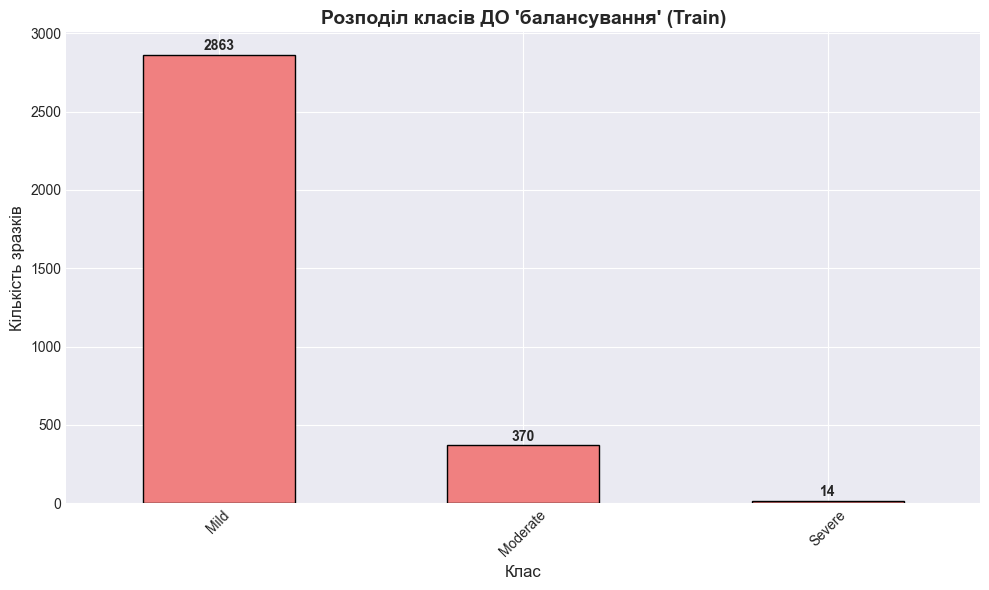

  Клас Mild: 2863 зразків (88.17%)
    Оригінальних: 2863, Синтетичних: 0 (0.0%)
  Клас Moderate: 370 зразків (11.40%)
    Оригінальних: 370, Синтетичних: 0 (0.0%)
  Клас Severe: 14 зразків (0.43%)
    Оригінальних: 14, Синтетичних: 0 (0.0%)

✅ ОБРОБКА ЗАВЕРШЕНА


In [13]:
from collections import Counter
from sklearn.utils import class_weight

print("\n" + "="*60)
print("КРОК 7: ОБРОБКА НЕЗБАЛАНСОВАНОСТІ (ВИПРАВЛЕННЯ)")
print("="*60)

train_dist = Counter(y_train)
print(f"\nРозподіл класів ДО балансування: {dict(train_dist)}")
print("⚠️ УВАГА: Бібліотека imblearn недоступна, тому data resampling пропущено.")
print("  Натомість ми використовуємо стратегію 'class_weight' для зважування класів")
print("  безпосередньо в моделі (як це вже налаштовано у комірці 30).")

# Визначаємо ваги класів для демонстрації (вони будуть використані пізніше моделлю)
# 0: Mild, 1: Moderate, 2: Severe
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Встановлення змінних для наступних комірок (X_train_scaled)
X_train_balanced = X_train_encoded
y_train_balanced = y_train
use_smote = False # Фактично SMOTE не використовується

print("\n✓ Розраховані ваги класів для моделі:")
for cls, weight in class_weight_dict.items():
    # Назви класів: 0=Mild, 1=Moderate, 2=Severe
    print(f"  Клас {le_target.classes_[cls]}: Вага {weight:.4f}")

# Виведення розподілу
balanced_dist = Counter(y_train_balanced)
print(f"\nРозподіл класів ПІСЛЯ 'балансування': {dict(balanced_dist)}")

# Візуалізація
plt.figure(figsize=(10, 6))
# Графік: Розподіл класів (показуємо тренувальний набір, який незбалансований)
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Розподіл класів ДО 'балансування' (Train)", fontsize=14, fontweight='bold')
plt.xlabel("Клас", fontsize=12)
plt.ylabel("Кількість зразків", fontsize=12)
# Використовуємо назви класів: 0:Mild, 1:Moderate, 2:Severe
plt.xticks(ticks=range(len(le_target.classes_)), labels=le_target.classes_, rotation=45)
for i, v in enumerate(pd.Series(y_train_balanced).value_counts().sort_index()):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Виведення детальної інформації
for cls, count in sorted(balanced_dist.items()):
    original_count = train_dist.get(cls, 0)
    synthetic_count = count - original_count
    synthetic_pct = (synthetic_count / count * 100) if count > original_count else 0
    print(f"  Клас {le_target.classes_[cls]}: {count} зразків ({count/len(y_train_balanced)*100:.2f}%)")
    print(f"    Оригінальних: {original_count}, Синтетичних: {synthetic_count} ({synthetic_pct:.1f}%)")

print("\n" + "="*60)
print("✅ ОБРОБКА ЗАВЕРШЕНА")
print("="*60)

In [14]:
print("\n" + "="*60)
print("КРОК 8: МАСШТАБУВАННЯ ДАНИХ")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_encoded)  # Використовуємо X_test_encoded

print("✓ Дані успішно масштабовані (StandardScaler)")


КРОК 8: МАСШТАБУВАННЯ ДАНИХ
✓ Дані успішно масштабовані (StandardScaler)


In [15]:
print("\n" + "="*60)
print("КРОК 9: НАВЧАННЯ МОДЕЛІ")
print("="*60)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Обмежуємо глибину
    min_samples_split=20,  # Більше зразків для розділення
    min_samples_leaf=10,  # Більше зразків у листі
    max_features='sqrt',  # Обмежуємо кількість ознак
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_balanced)

print("✓ Модель Random Forest навчена з обмеженнями проти overfitting")

# Додаємо крос-валідацію
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X_train_scaled, y_train_balanced, cv=5, scoring='f1_macro')
print(f"\n🔍 Cross-validation F1-macro: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"   Окремі fold'и: {[f'{s:.4f}' for s in cv_scores]}")


КРОК 9: НАВЧАННЯ МОДЕЛІ
✓ Модель Random Forest навчена з обмеженнями проти overfitting

🔍 Cross-validation F1-macro: 0.7659 (+/- 0.1054)
   Окремі fold'и: ['0.8185', '0.9153', '0.6442', '0.8047', '0.6470']



КРОК 10: ОЦІНКА МОДЕЛІ

📊 РЕЗУЛЬТАТИ:
  Accuracy: 0.9840 ⚠️ (може бути оманливою!)
  F1-score (MACRO): 0.8066 👈 ВАЖЛИВІША МЕТРИКА
  F1-score (weighted): 0.9831
  MCC: 0.9215

🔍 ПЕРЕВІРКА НА OVERFITTING:
  Train accuracy: 1.0000
  Test accuracy: 0.9840
  Різниця: 0.0160
  ✅ Модель генералізує нормально

📈 МЕТРИКИ ПО КЛАСАХ:
  Mild:
    Precision: 0.9862 | Recall: 0.9986 | F1: 0.9924 | Support: 716
  Moderate:
    Precision: 0.9651 | Recall: 0.8925 | F1: 0.9274 | Support: 93
  Severe:
    Precision: 1.0000 | Recall: 0.3333 | F1: 0.5000 | Support: 3

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Mild     0.9862    0.9986    0.9924       716
    Moderate     0.9651    0.8925    0.9274        93
      Severe     1.0000    0.3333    0.5000         3

    accuracy                         0.9840       812
   macro avg     0.9838    0.7415    0.8066       812
weighted avg     0.9838    0.9840    0.9831       812



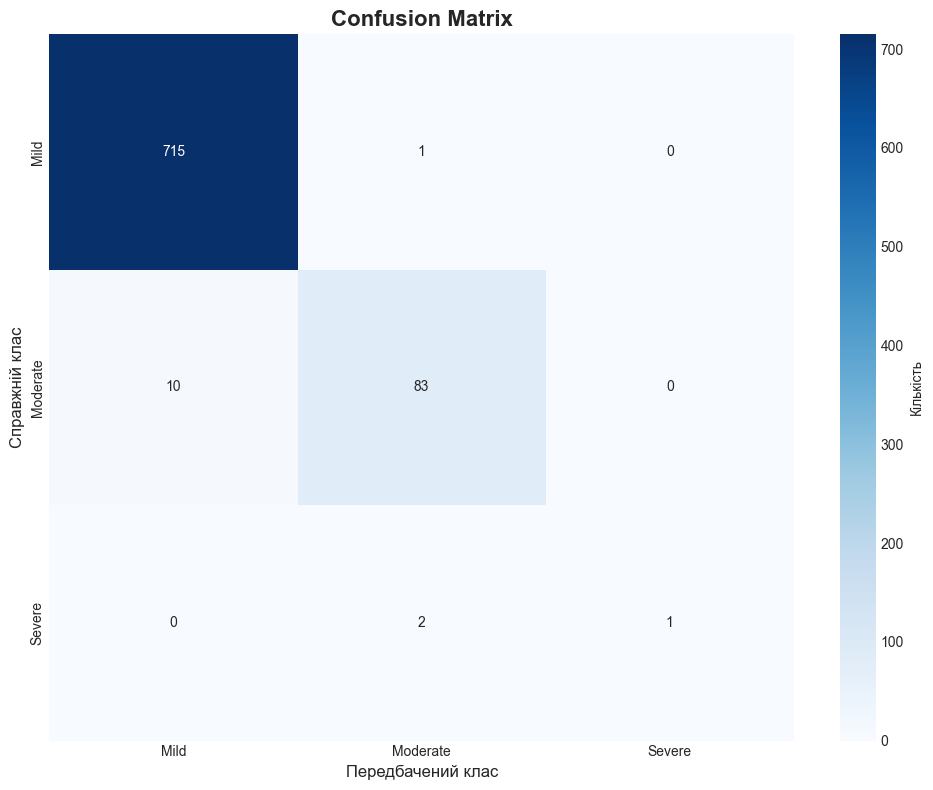


✅ ОБРОБКА ЗАВЕРШЕНА


In [16]:
print("\n" + "="*60)
print("КРОК 10: ОЦІНКА МОДЕЛІ")
print("="*60)

y_pred = model.predict(X_test_scaled)

# Метрики
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')  # MACRO замість weighted!
f1_weighted = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Додаткові метрики для кожного класу
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

print(f"\n📊 РЕЗУЛЬТАТИ:")
print(f"  Accuracy: {accuracy:.4f} ⚠️ (може бути оманливою!)")
print(f"  F1-score (MACRO): {f1_macro:.4f} 👈 ВАЖЛИВІША МЕТРИКА")
print(f"  F1-score (weighted): {f1_weighted:.4f}")
print(f"  MCC: {mcc:.4f}")

# Перевірка на overfitting
y_train_pred = model.predict(X_train_scaled[:1000])  # Беремо перші 1000 для швидкості
train_accuracy = accuracy_score(y_train_balanced[:1000], y_train_pred)
print(f"\n🔍 ПЕРЕВІРКА НА OVERFITTING:")
print(f"  Train accuracy: {train_accuracy:.4f}")
print(f"  Test accuracy: {accuracy:.4f}")
print(f"  Різниця: {abs(train_accuracy - accuracy):.4f}")
if abs(train_accuracy - accuracy) > 0.15:
    print("  ⚠️ УВАГА: Можливе переобучення!")
else:
    print("  ✅ Модель генералізує нормально")

print(f"\n📈 МЕТРИКИ ПО КЛАСАХ:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name}:")
    print(f"    Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f} | Support: {support[i]}")

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=le_target.classes_, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_,
            cbar_kws={'label': 'Кількість'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Справжній клас', fontsize=12)
plt.xlabel('Передбачений клас', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ ОБРОБКА ЗАВЕРШЕНА")
print("="*60)

In [17]:
cm = confusion_matrix(y_test, y_pred)
classes = le_target.classes_
print(cm)

for idx, class_name in enumerate(classes):
    TP = cm[idx, idx]
    FN = cm[idx, :].sum() - TP
    FP = cm[:, idx].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"  {class_name}:")
    print(f"    Sensitivity (Recall): {sensitivity:.4f}")
    print(f"    Specificity:          {specificity:.4f}")

[[715   1   0]
 [ 10  83   0]
 [  0   2   1]]
  Mild:
    Sensitivity (Recall): 0.9986
    Specificity:          0.8958
  Moderate:
    Sensitivity (Recall): 0.8925
    Specificity:          0.9958
  Severe:
    Sensitivity (Recall): 0.3333
    Specificity:          1.0000


In [18]:
X_processed = X.copy()

# Початковий список категоріальних колонок
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                    'Occupation', 'Smoking', 'Alcohol_Consumption']

# Фільтруємо тільки ті, що реально є в датафреймі
categorical_cols = [col for col in categorical_cols if col in X_processed.columns]
numerical_cols = [col for col in X_processed.columns if col not in categorical_cols]

print("\n" + "="*60)
print("КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ")
print("="*60)
print("\nКатегоріальні колонки:", categorical_cols)
print("Числові колонки:", numerical_cols)

# Перевірка унікальних значень
print("\nУнікальні значення категоріальних змінних:")
for col in categorical_cols:
    print(f"  {col}: {X_processed[col].nunique()} унікальних значень")
    print(f"    {X_processed[col].unique()[:5]}...")

# Безпечне one-hot кодування
X_processed = pd.get_dummies(X_processed, columns=categorical_cols, drop_first=False)

print(f"\nРозмірність після кодування: {X_processed.shape}")
print(f"Кількість ознак: {X_processed.shape[1]}")
print(f"\nПриклад нових колонок (перші 10):")
print(list(X_processed.columns[:10]))


КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ

Категоріальні колонки: ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Числові колонки: ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']

Унікальні значення категоріальних змінних:
  Gender: 3 унікальних значень
    ['Male' 'Female' 'Other']...
  Country: 20 унікальних значень
    ['Brazil' 'Germany' 'Spain' 'France' 'Canada']...
  Sleep_Quality: 4 унікальних значень
    ['Fair' 'Good' 'Poor' 'Excellent']...
  Stress_Level: 3 унікальних значень
    ['Medium' 'Low' 'High']...
  Occupation: 5 унікальних значень
    ['Office' 'Other' 'Student' 'Service' 'Healthcare']...
  Smoking: 2 унікальних значень
    [0 1]...
  Alcohol_Consumption: 2 унікальних значень
    [0 1]...

Розмірність після кодування: (4059, 46)
Кількість ознак: 46

Приклад нових колонок (перші 10):
['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physica

In [19]:
print("\n" + "="*60)
print("РОЗДІЛЕННЯ ДАНИХ")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed.values, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

print("\nРозподіл класів у тренувальній вибірці:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Клас {le_target.classes_[u]}: {c} ({c/len(y_train)*100:.2f}%)")

print("\nРозподіл класів у тестовій вибірці:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Клас {le_target.classes_[u]}: {c} ({c/len(y_test)*100:.2f}%)")


РОЗДІЛЕННЯ ДАНИХ

Розмір тренувальної вибірки: (3247, 46)
Розмір тестової вибірки: (812, 46)

Розподіл класів у тренувальній вибірці:
  Клас Mild: 2863 (88.17%)
  Клас Moderate: 370 (11.40%)
  Клас Severe: 14 (0.43%)

Розподіл класів у тестовій вибірці:
  Клас Mild: 716 (88.18%)
  Клас Moderate: 93 (11.45%)
  Клас Severe: 3 (0.37%)


In [20]:
print("\n" + "="*60)
print("a) РЕАЛІЗАЦІЯ MYDECISIONTREE З GINI INDEX")
print("="*60)

class MyDecisionTree:
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        self.n_features = None
        self.n_classes = None
        self.n_total = None
    
    def gini(self, y):
        """Обчислення Gini impurity для вузла"""
        if len(y) == 0:
            return 0
        classes, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        return 1 - np.sum(proportions ** 2)
    
    def best_split(self, X, y):
        """Знаходження найкращого розділу за Gini index"""
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        best_gini_reduction = 0
        
        n_samples = len(y)
        if n_samples <= 1:
            return None, None, best_gini, 0
        
        parent_gini = self.gini(y)
        
        for feature in range(X.shape[1]):
            # Отримання унікальних значень для порогів
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Розділення на ліве та праве піддерево
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples or np.sum(right_mask) < self.min_samples:
                    continue
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                # Обчислення зваженої Gini після розділу
                n_left, n_right = len(y_left), len(y_right)
                weighted_gini = (n_left / n_samples) * self.gini(y_left) + \
                               (n_right / n_samples) * self.gini(y_right)
                
                # Оновлення найкращого розділу
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
                    best_gini_reduction = parent_gini - weighted_gini
        
        return best_feature, best_threshold, best_gini, best_gini_reduction
    
    def build_tree(self, X, y, depth=0):
        """Рекурсивна побудова дерева рішень"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Критерії зупинки
        if depth >= self.max_depth or n_samples < self.min_samples or n_classes == 1:
            leaf_value = np.bincount(y).argmax()
            return {'leaf': True, 'class': leaf_value, 'samples': n_samples}
        
        # Знаходження найкращого розділу
        feature, threshold, gini, gini_reduction = self.best_split(X, y)
        
        if feature is None:
            leaf_value = np.bincount(y).argmax()
            return {'leaf': True, 'class': leaf_value, 'samples': n_samples}
        
        # Оновлення важливості ознак
        # Важливість = (n_samples / n_total) * gini_reduction
        importance_value = (n_samples / self.n_total) * gini_reduction
        self.feature_importance[feature] += importance_value
        
        # Розділення даних
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        # Рекурсивна побудова піддерев
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'samples': n_samples,
            'gini': gini
        }
    
    def fit(self, X, y):
        """Навчання дерева та обчислення важливості ознак"""
        self.n_features = X.shape[1]
        self.n_classes = len(np.unique(y))
        self.n_total = len(y)
        self.feature_importance = np.zeros(self.n_features)
        
        # Побудова дерева
        self.tree = self.build_tree(X, y)
        
        # Нормалізація важливості
        if np.sum(self.feature_importance) > 0:
            self.feature_importance /= np.sum(self.feature_importance)
        
        return self
    
    def predict_one(self, x, node):
        """Прогнозування класу для одного зразка"""
        if node['leaf']:
            return node['class']
        
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])
    
    def predict(self, X):
        """Прогнозування класів для всіх зразків"""
        return np.array([self.predict_one(x, self.tree) for x in X])

print("\nКлас MyDecisionTree успішно створено!")


a) РЕАЛІЗАЦІЯ MYDECISIONTREE З GINI INDEX

Клас MyDecisionTree успішно створено!


In [21]:
print("\n" + "="*60)
print("НАВЧАННЯ ТА ОЦІНКА MYDECISIONTREE")
print("="*60)

# Створення та навчання моделі
start_time = time.time()
my_tree = MyDecisionTree(max_depth=10, min_samples=5)
my_tree.fit(X_train, y_train)
train_time = time.time() - start_time

# Прогнозування
start_time = time.time()
y_pred_my = my_tree.predict(X_test)
pred_time = time.time() - start_time

# Обчислення метрик
accuracy_my = accuracy_score(y_test, y_pred_my)
f1_my = f1_score(y_test, y_pred_my, average='weighted')
mcc_my = matthews_corrcoef(y_test, y_pred_my)
cm_my = confusion_matrix(y_test, y_pred_my)

print(f"\nЧас навчання: {train_time:.4f} сек")
print(f"Час прогнозування: {pred_time:.4f} сек")
print(f"\nAccuracy: {accuracy_my:.4f}")
print(f"F1-score (weighted): {f1_my:.4f}")
print(f"MCC: {mcc_my:.4f}")

print("\nConfusion Matrix:")
print(cm_my)


НАВЧАННЯ ТА ОЦІНКА MYDECISIONTREE

Час навчання: 0.7370 сек
Час прогнозування: 0.0000 сек

Accuracy: 0.9951
F1-score (weighted): 0.9950
MCC: 0.9763

Confusion Matrix:
[[716   0   0]
 [  4  89   0]
 [  0   0   3]]


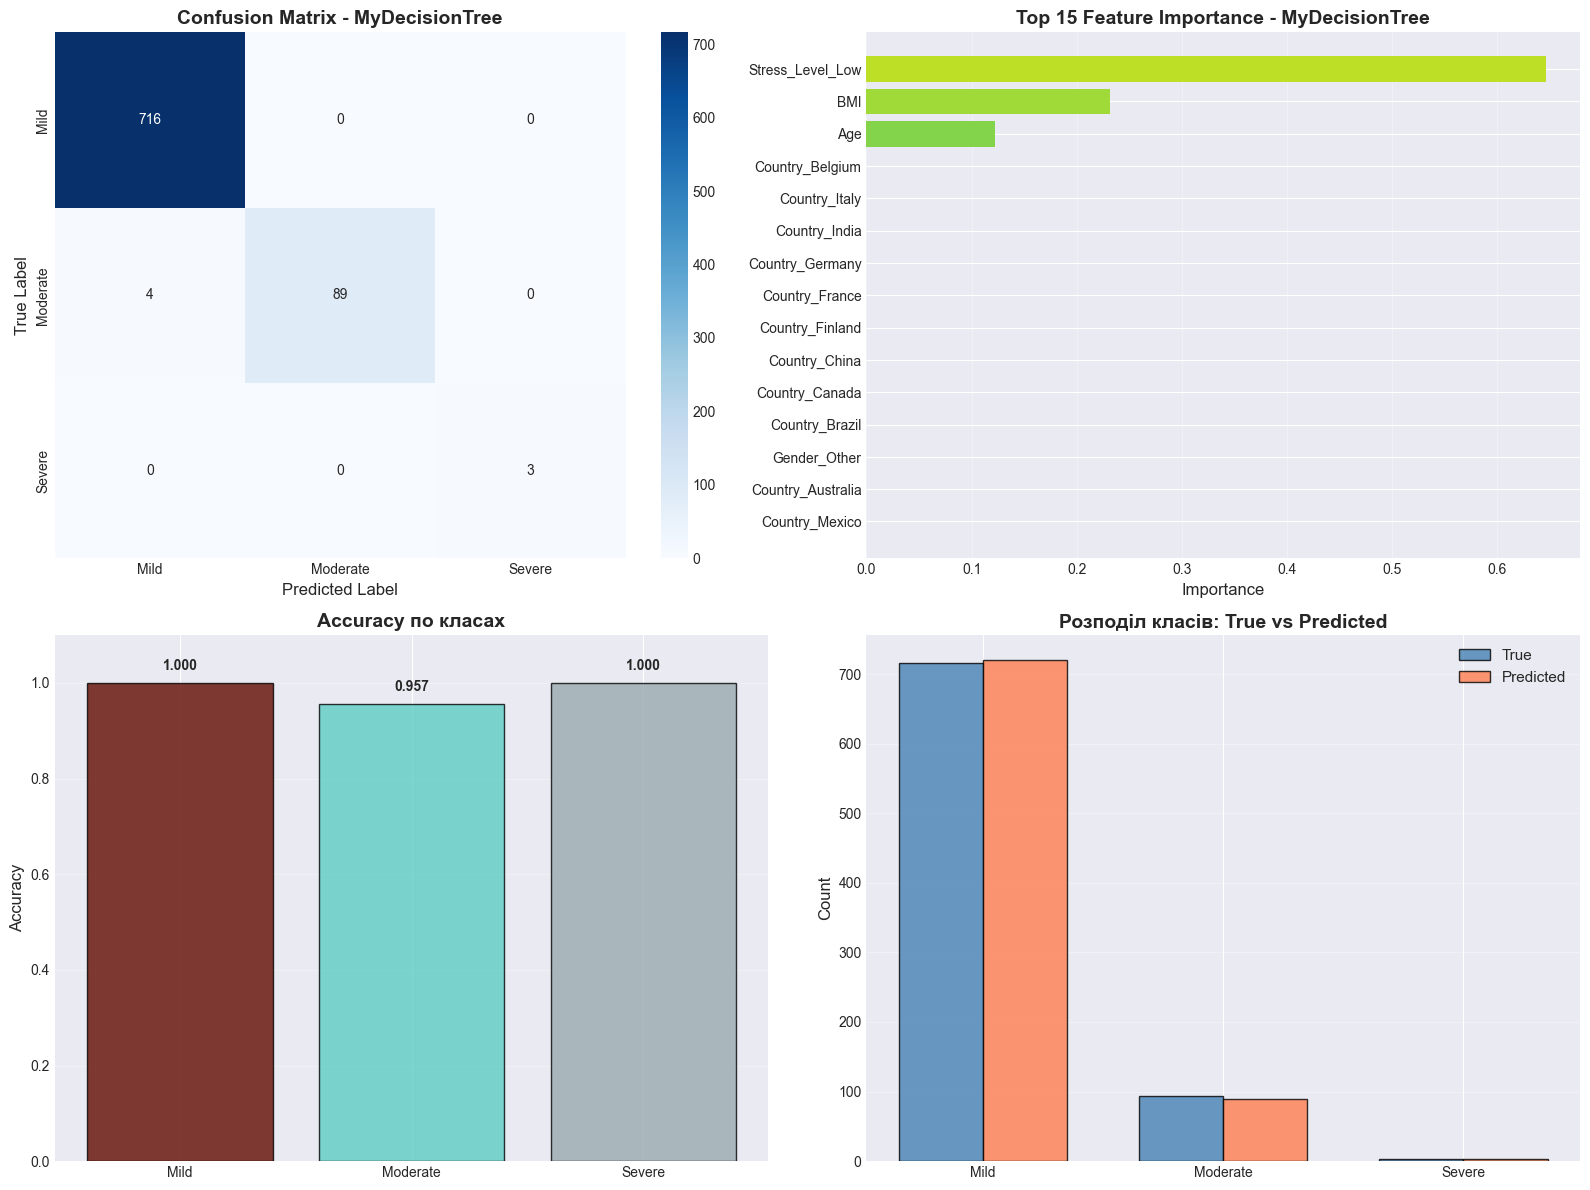


✓ Візуалізація MyDecisionTree завершена!


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
sns.heatmap(cm_my, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
axes[0, 0].set_title('Confusion Matrix - MyDecisionTree', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)

# 2. Feature Importance
feature_names = X_processed.columns
top_n = 15
indices = np.argsort(my_tree.feature_importance)[-top_n:]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))

axes[0, 1].barh(range(top_n), my_tree.feature_importance[indices], color=colors)
axes[0, 1].set_yticks(range(top_n))
axes[0, 1].set_yticklabels([feature_names[i] for i in indices], fontsize=10)
axes[0, 1].set_xlabel('Importance', fontsize=12)
axes[0, 1].set_title(f'Top {top_n} Feature Importance - MyDecisionTree', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Метрики по класах
classes = le_target.classes_
class_accuracies = []
for i, cls in enumerate(classes):
    mask = y_test == i
    if np.sum(mask) > 0:
        acc = accuracy_score(y_test[mask], y_pred_my[mask])
        class_accuracies.append(acc)
    else:
        class_accuracies.append(0)

colors_bar = ["#610B01", '#5ECDC4', "#99AAAE", "#DB5B28"]
bars = axes[1, 0].bar([str(c) for c in classes], class_accuracies,
                      color=colors_bar, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Accuracy по класах', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

for i, (bar, v) in enumerate(zip(bars, class_accuracies)):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Розподіл передбачень
unique_pred, counts_pred = np.unique(y_pred_my, return_counts=True)
pred_distribution = np.zeros(len(classes))
for i, count in zip(unique_pred, counts_pred):
    pred_distribution[i] = count

unique_true, counts_true = np.unique(y_test, return_counts=True)
true_distribution = np.zeros(len(classes))
for i, count in zip(unique_true, counts_true):
    true_distribution[i] = count

x = np.arange(len(classes))
width = 0.35
bars1 = axes[1, 1].bar(x - width/2, true_distribution, width, label='True', 
                       alpha=0.8, color='steelblue', edgecolor='black')
bars2 = axes[1, 1].bar(x + width/2, pred_distribution, width, label='Predicted', 
                       alpha=0.8, color='coral', edgecolor='black')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Розподіл класів: True vs Predicted', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Візуалізація MyDecisionTree завершена!")

In [23]:
print("\n" + "="*60)
print("б) РЕАЛІЗАЦІЯ COST-COMPLEXITY PRUNING")
print("="*60)

class MyDecisionTreeWithPruning(MyDecisionTree):
    def __init__(self, max_depth=5, min_samples=2, alpha=0.01):
        super().__init__(max_depth, min_samples)
        self.alpha = alpha
        self.pruned_tree = None
    
    def count_leaves(self, node):
        """Підрахунок кількості листів у дереві/піддереві"""
        if node is None or node.get('leaf', False):
            return 1
        return self.count_leaves(node.get('left')) + self.count_leaves(node.get('right'))
    
    def calculate_error(self, X, y, node):
        """Обчислення помилки на валідаційних даних"""
        if len(y) == 0:
            return 0
        predictions = self.predict_with_node(X, node)
        return np.sum(predictions != y)
    
    def predict_with_node(self, X, node):
        """Прогнозування з використанням конкретного вузла"""
        if node.get('leaf', False):
            return np.full(len(X), node['class'])
        
        predictions = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):
            predictions[i] = self.predict_one(x, node)
        return predictions
    
    def prune_tree(self, node, X_val, y_val):
        """Рекурсивний прунінг дерева"""
        if node is None or node.get('leaf', False):
            return node
        
        # Рекурсивно обрізаємо піддерева
        if 'left' in node:
            node['left'] = self.prune_tree(node['left'], X_val, y_val)
        if 'right' in node:
            node['right'] = self.prune_tree(node['right'], X_val, y_val)
        
        # Перевіряємо, чи обидва піддерева є листями
        left_is_leaf = node.get('left', {}).get('leaf', False)
        right_is_leaf = node.get('right', {}).get('leaf', False)
        
        if left_is_leaf and right_is_leaf:
            # Обчислюємо помилку для поточного піддерева
            current_error = self.calculate_error(X_val, y_val, node)
            
            # Створюємо листовий вузол
            leaf_node = {
                'leaf': True,
                'class': self._majority_class(node),
                'samples': node.get('samples', 0)
            }
            
            # Обчислюємо помилку для листового вузла
            leaf_error = self.calculate_error(X_val, y_val, leaf_node)
            
            # Обчислюємо cost-complexity
            num_leaves = self.count_leaves(node)
            subtree_cost = current_error + self.alpha * num_leaves
            leaf_cost = leaf_error + self.alpha * 1
            
            # Якщо листовий вузол кращий, замінюємо
            if leaf_cost <= subtree_cost:
                return leaf_node
        
        return node
    
    def _majority_class(self, node):
        """Знаходження класу більшості для вузла"""
        if node.get('leaf', False):
            return node['class']
        
        # Рекурсивно збираємо всі класи з піддерев
        classes = []
        self._collect_classes(node, classes)
        
        if len(classes) > 0:
            return np.bincount(classes).argmax()
        return 0
    
    def _collect_classes(self, node, classes):
        """Збір всіх класів з листових вузлів"""
        if node.get('leaf', False):
            # Додаємо клас стільки разів, скільки зразків у листі
            classes.extend([node['class']] * node.get('samples', 1))
        else:
            if 'left' in node:
                self._collect_classes(node['left'], classes)
            if 'right' in node:
                self._collect_classes(node['right'], classes)
    
    def fit_with_pruning(self, X_train, y_train, X_val, y_val):
        """Навчання дерева з подальшим прунінгом"""
        # Спочатку будуємо повне дерево
        self.fit(X_train, y_train)
        
        leaves_before = self.count_leaves(self.tree)
        print(f"Дерево до прунінгу: {leaves_before} листів")
        
        # Застосовуємо прунінг
        import copy
        self.pruned_tree = copy.deepcopy(self.tree)
        self.pruned_tree = self.prune_tree(self.pruned_tree, X_val, y_val)
        
        leaves_after = self.count_leaves(self.pruned_tree)
        print(f"Дерево після прунінгу: {leaves_after} листів")
        print(f"Зменшення кількості листів: {leaves_before - leaves_after} ({(1 - leaves_after/leaves_before)*100:.2f}%)")
        
        # Переобчислюємо feature importance на pruned tree
        self.feature_importance = np.zeros(self.n_features)
        self._recalculate_importance(self.pruned_tree, X_train, y_train)
        
        if np.sum(self.feature_importance) > 0:
            self.feature_importance /= np.sum(self.feature_importance)
        
        return self
    
    def _recalculate_importance(self, node, X, y):
        """Переобчислення важливості ознак для pruned tree"""
        if node.get('leaf', False) or len(y) == 0:
            return
        
        feature = node.get('feature')
        threshold = node.get('threshold')
        
        if feature is not None and threshold is not None:
            # Розділення даних
            left_mask = X[:, feature] <= threshold
            right_mask = ~left_mask
            
            y_left = y[left_mask]
            y_right = y[right_mask]
            
            if len(y_left) > 0 and len(y_right) > 0:
                # Обчислення Gini reduction
                parent_gini = self.gini(y)
                left_gini = self.gini(y_left)
                right_gini = self.gini(y_right)
                
                n_left, n_right = len(y_left), len(y_right)
                n_total = len(y)
                
                weighted_gini = (n_left / n_total) * left_gini + (n_right / n_total) * right_gini
                gini_reduction = parent_gini - weighted_gini
                
                # Оновлення важливості
                importance_value = (n_total / self.n_total) * gini_reduction
                self.feature_importance[feature] += importance_value
                
                # Рекурсія для піддерев
                if 'left' in node:
                    self._recalculate_importance(node['left'], X[left_mask], y_left)
                if 'right' in node:
                    self._recalculate_importance(node['right'], X[right_mask], y_right)
    
    def predict_pruned(self, X):
        """Прогнозування з використанням pruned tree"""
        if self.pruned_tree is None:
            raise ValueError("Дерево не було обрізане. Спочатку викличте fit_with_pruning()")
        return np.array([self.predict_one(x, self.pruned_tree) for x in X])

print("\n✓ Клас MyDecisionTreeWithPruning створено!")


б) РЕАЛІЗАЦІЯ COST-COMPLEXITY PRUNING

✓ Клас MyDecisionTreeWithPruning створено!


In [24]:
print("\n" + "="*60)
print("ПІДГОТОВКА ДАНИХ ДЛЯ PRUNING")
print("="*60)

# Розділення тренувальних даних на train/validation для прунінгу
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\nTrain split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")
print(f"Test set: {X_test.shape}")

print("\nРозподіл класів у validation split:")
unique, counts = np.unique(y_val_split, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Клас {le_target.classes_[u]}: {c} ({c/len(y_val_split)*100:.2f}%)")


ПІДГОТОВКА ДАНИХ ДЛЯ PRUNING

Train split: (2597, 46)
Validation split: (650, 46)
Test set: (812, 46)

Розподіл класів у validation split:
  Клас Mild: 573 (88.15%)
  Клас Moderate: 74 (11.38%)
  Клас Severe: 3 (0.46%)


In [25]:
print("\n" + "="*60)
print("ПІДБІР ОПТИМАЛЬНОГО ALPHA")
print("="*60)

alphas = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]
pruning_results = []

for alpha in alphas:
    print(f"\n{'─'*50}")
    print(f"Тестування alpha = {alpha}")
    print(f"{'─'*50}")
    
    # Створення та навчання моделі з прунінгом
    tree_pruned = MyDecisionTreeWithPruning(max_depth=15, min_samples=2, alpha=alpha)
    
    start_time = time.time()
    tree_pruned.fit_with_pruning(X_train_split, y_train_split, X_val_split, y_val_split)
    train_time = time.time() - start_time
    
    # Прогнозування на тестових даних
    y_pred_pruned = tree_pruned.predict_pruned(X_test)
    
    # Метрики
    acc = accuracy_score(y_test, y_pred_pruned)
    f1 = f1_score(y_test, y_pred_pruned, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_pruned)
    cm = confusion_matrix(y_test, y_pred_pruned)
    
    pruning_results.append({
        'alpha': alpha,
        'accuracy': acc,
        'f1_score': f1,
        'mcc': mcc,
        'n_leaves': tree_pruned.count_leaves(tree_pruned.pruned_tree),
        'train_time': train_time
    })
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Час навчання: {train_time:.4f} сек")

# Вибір найкращого alpha
pruning_df = pd.DataFrame(pruning_results)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ PRUNING")
print("="*60)
print("\n", pruning_df.to_string(index=False))

best_alpha_idx = pruning_df['f1_score'].idxmax()
best_alpha = pruning_df.loc[best_alpha_idx, 'alpha']

print(f"\n{'='*60}")
print(f"Найкращий alpha: {best_alpha}")
print(f"  Accuracy: {pruning_df.loc[best_alpha_idx, 'accuracy']:.4f}")
print(f"  F1-score: {pruning_df.loc[best_alpha_idx, 'f1_score']:.4f}")
print(f"  MCC: {pruning_df.loc[best_alpha_idx, 'mcc']:.4f}")
print(f"  Кількість листів: {pruning_df.loc[best_alpha_idx, 'n_leaves']}")
print(f"{'='*60}")


ПІДБІР ОПТИМАЛЬНОГО ALPHA

──────────────────────────────────────────────────
Тестування alpha = 0.0
──────────────────────────────────────────────────
Дерево до прунінгу: 10 листів
Дерево після прунінгу: 5 листів
Зменшення кількості листів: 5 (50.00%)
Accuracy: 0.9187
F1-score: 0.8988
MCC: 0.5349
Час навчання: 0.6273 сек

──────────────────────────────────────────────────
Тестування alpha = 0.001
──────────────────────────────────────────────────
Дерево до прунінгу: 10 листів
Дерево після прунінгу: 5 листів
Зменшення кількості листів: 5 (50.00%)
Accuracy: 0.9187
F1-score: 0.8988
MCC: 0.5349
Час навчання: 0.6055 сек

──────────────────────────────────────────────────
Тестування alpha = 0.005
──────────────────────────────────────────────────
Дерево до прунінгу: 10 листів
Дерево після прунінгу: 5 листів
Зменшення кількості листів: 5 (50.00%)
Accuracy: 0.9187
F1-score: 0.8988
MCC: 0.5349
Час навчання: 0.5861 сек

──────────────────────────────────────────────────
Тестування alpha = 0.01


ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ PRUNING

Обчислення feature importance для порівняння...
Дерево до прунінгу: 10 листів
Дерево після прунінгу: 5 листів
Зменшення кількості листів: 5 (50.00%)
Дерево до прунінгу: 10 листів
Дерево після прунінгу: 5 листів
Зменшення кількості листів: 5 (50.00%)


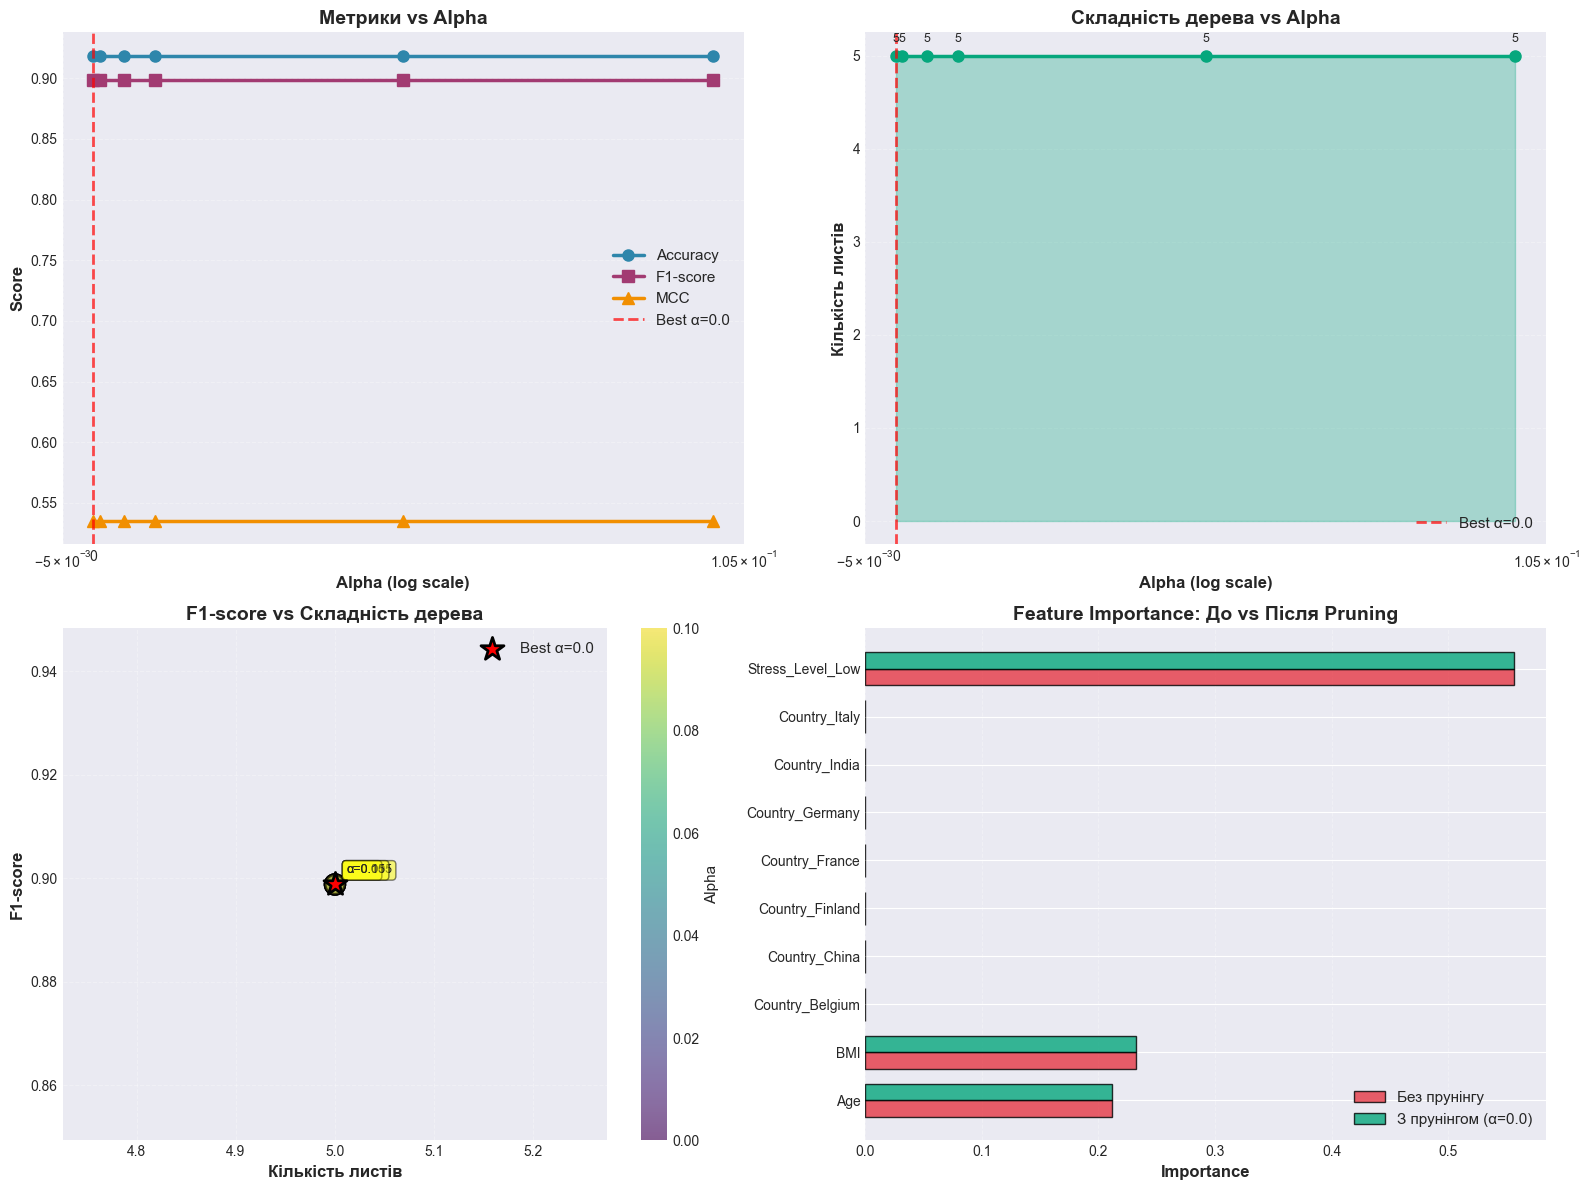


✓ Візуалізація Pruning завершена!


In [26]:
print("\n" + "="*60)
print("ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ PRUNING")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Залежність метрик від alpha
axes[0, 0].plot(pruning_df['alpha'], pruning_df['accuracy'], 'o-', 
                label='Accuracy', linewidth=2.5, markersize=8, color='#2E86AB')
axes[0, 0].plot(pruning_df['alpha'], pruning_df['f1_score'], 's-', 
                label='F1-score', linewidth=2.5, markersize=8, color='#A23B72')
axes[0, 0].plot(pruning_df['alpha'], pruning_df['mcc'], '^-', 
                label='MCC', linewidth=2.5, markersize=8, color='#F18F01')
axes[0, 0].set_xlabel('Alpha (log scale)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Метрики vs Alpha', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11, loc='best')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].set_xscale('symlog')

# Позначити найкращий alpha
best_row = pruning_df.loc[best_alpha_idx]
axes[0, 0].axvline(x=best_row['alpha'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Best α={best_row["alpha"]}')
axes[0, 0].legend(fontsize=11, loc='best')

# 2. Кількість листів vs Alpha
axes[0, 1].plot(pruning_df['alpha'], pruning_df['n_leaves'], 'o-', 
                color='#06A77D', linewidth=2.5, markersize=8)
axes[0, 1].fill_between(pruning_df['alpha'], pruning_df['n_leaves'], 
                        alpha=0.3, color='#06A77D')
axes[0, 1].set_xlabel('Alpha (log scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Кількість листів', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Складність дерева vs Alpha', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
axes[0, 1].set_xscale('symlog')

# Позначити найкращий alpha
axes[0, 1].axvline(x=best_row['alpha'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Best α={best_row["alpha"]}')
axes[0, 1].legend(fontsize=11)

# Додати значення на точках
for i, row in pruning_df.iterrows():
    axes[0, 1].annotate(f'{int(row["n_leaves"])}', 
                       (row['alpha'], row['n_leaves']),
                       textcoords="offset points", xytext=(0,10), 
                       ha='center', fontsize=9)

# 3. Trade-off: F1-score vs Complexity
scatter = axes[1, 0].scatter(pruning_df['n_leaves'], pruning_df['f1_score'], 
                            s=200, alpha=0.6, c=pruning_df['alpha'], 
                            cmap='viridis', edgecolors='black', linewidth=2)
axes[1, 0].plot(pruning_df['n_leaves'], pruning_df['f1_score'], 
               '--', alpha=0.5, color='gray')

# Позначити найкращий результат
axes[1, 0].scatter(best_row['n_leaves'], best_row['f1_score'], 
                  s=300, marker='*', color='red', edgecolors='black', 
                  linewidth=2, label=f'Best α={best_row["alpha"]}', zorder=5)

for i, row in pruning_df.iterrows():
    axes[1, 0].annotate(f'α={row["alpha"]}', 
                       (row['n_leaves'], row['f1_score']),
                       xytext=(8, 8), textcoords='offset points', 
                       fontsize=9, bbox=dict(boxstyle='round,pad=0.3', 
                       facecolor='yellow', alpha=0.3))

axes[1, 0].set_xlabel('Кількість листів', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('F1-score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('F1-score vs Складність дерева', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].legend(fontsize=11)

cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Alpha', fontsize=11)

# 4. Порівняння важливості ознак до і після прунінгу
print("\nОбчислення feature importance для порівняння...")

tree_no_prune = MyDecisionTreeWithPruning(max_depth=15, min_samples=2, alpha=0.0)
tree_no_prune.fit_with_pruning(X_train_split, y_train_split, X_val_split, y_val_split)

tree_best_prune = MyDecisionTreeWithPruning(max_depth=15, min_samples=2, alpha=best_alpha)
tree_best_prune.fit_with_pruning(X_train_split, y_train_split, X_val_split, y_val_split)

top_n = 10
indices_no_prune = np.argsort(tree_no_prune.feature_importance)[-top_n:]
indices_best_prune = np.argsort(tree_best_prune.feature_importance)[-top_n:]

# Об'єднання індексів для порівняння
all_indices = np.unique(np.concatenate([indices_no_prune, indices_best_prune]))
if len(all_indices) > top_n:
    # Вибираємо топ за сумарною важливістю
    combined_importance = tree_no_prune.feature_importance + tree_best_prune.feature_importance
    all_indices = np.argsort(combined_importance)[-top_n:]

x = np.arange(len(all_indices))
width = 0.35

imp_no_prune = tree_no_prune.feature_importance[all_indices]
imp_best_prune = tree_best_prune.feature_importance[all_indices]

bars1 = axes[1, 1].barh(x - width/2, imp_no_prune, width, 
                       label='Без прунінгу', alpha=0.8, color='#E63946', edgecolor='black')
bars2 = axes[1, 1].barh(x + width/2, imp_best_prune, width, 
                       label=f'З прунінгом (α={best_alpha})', alpha=0.8, 
                       color='#06A77D', edgecolor='black')

axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels([feature_names[i] for i in all_indices], fontsize=10)
axes[1, 1].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Feature Importance: До vs Після Pruning', 
                    fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11, loc='best')
axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Візуалізація Pruning завершена!")

In [27]:
print("\n" + "="*60)
print("в) ПОРІВНЯННЯ З SKLEARN МОДЕЛЯМИ")
print("="*60)

# 1. sklearn DecisionTreeClassifier
print("\n" + "─"*50)
print("1. sklearn DecisionTreeClassifier")
print("─"*50)

start_time = time.time()
dt_sklearn = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                                   min_samples_split=5, random_state=42)
dt_sklearn.fit(X_train, y_train)
train_time_dt_sk = time.time() - start_time

start_time = time.time()
y_pred_dt_sk = dt_sklearn.predict(X_test)
pred_time_dt_sk = time.time() - start_time

acc_dt_sk = accuracy_score(y_test, y_pred_dt_sk)
f1_dt_sk = f1_score(y_test, y_pred_dt_sk, average='weighted')
mcc_dt_sk = matthews_corrcoef(y_test, y_pred_dt_sk)
cm_dt_sk = confusion_matrix(y_test, y_pred_dt_sk)

print(f"Час навчання: {train_time_dt_sk:.4f} сек")
print(f"Час прогнозування: {pred_time_dt_sk:.4f} сек")
print(f"Accuracy: {acc_dt_sk:.4f}")
print(f"F1-score: {f1_dt_sk:.4f}")
print(f"MCC: {mcc_dt_sk:.4f}")

# 2. sklearn RandomForestClassifier
print("\n" + "─"*50)
print("2. sklearn RandomForestClassifier")
print("─"*50)

start_time = time.time()
rf_sklearn = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                   max_depth=10, min_samples_split=5,
                                   random_state=42, n_jobs=-1)
rf_sklearn.fit(X_train, y_train)
train_time_rf = time.time() - start_time

start_time = time.time()
y_pred_rf = rf_sklearn.predict(X_test)
pred_time_rf = time.time() - start_time

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Час навчання: {train_time_rf:.4f} сек")
print(f"Час прогнозування: {pred_time_rf:.4f} сек")
print(f"Accuracy: {acc_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"MCC: {mcc_rf:.4f}")


в) ПОРІВНЯННЯ З SKLEARN МОДЕЛЯМИ

──────────────────────────────────────────────────
1. sklearn DecisionTreeClassifier
──────────────────────────────────────────────────
Час навчання: 0.0083 сек
Час прогнозування: 0.0010 сек
Accuracy: 0.9926
F1-score: 0.9925
MCC: 0.9643

──────────────────────────────────────────────────
2. sklearn RandomForestClassifier
──────────────────────────────────────────────────
Час навчання: 0.1263 сек
Час прогнозування: 0.0287 сек
Accuracy: 0.9803
F1-score: 0.9791
MCC: 0.9028


In [28]:
print("\n" + "="*60)
print("КРОС-ВАЛІДАЦІЯ (5-FOLD)")
print("="*60)

# MyDecisionTree (використаємо sklearn обгортку для крос-валідації)
from sklearn.base import BaseEstimator, ClassifierMixin

class MyDTWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=10, min_samples=5):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
    
    def fit(self, X, y):
        self.tree = MyDecisionTree(max_depth=self.max_depth, min_samples=self.min_samples)
        self.tree.fit(X, y)
        return self
    
    def predict(self, X):
        return self.tree.predict(X)

print("\n1. MyDecisionTree:")
my_dt_wrapper = MyDTWrapper(max_depth=10, min_samples=5)
cv_scores_my = cross_val_score(my_dt_wrapper, X_train, y_train, cv=5, 
                               scoring='f1_weighted', n_jobs=-1)
print(f"   F1-score (5-fold CV): {cv_scores_my.mean():.4f} (+/- {cv_scores_my.std() * 2:.4f})")
print(f"   Scores по fold'ам: {cv_scores_my}")

print("\n2. sklearn DecisionTree:")
cv_scores_dt_sk = cross_val_score(dt_sklearn, X_train, y_train, cv=5, 
                                  scoring='f1_weighted', n_jobs=-1)
print(f"   F1-score (5-fold CV): {cv_scores_dt_sk.mean():.4f} (+/- {cv_scores_dt_sk.std() * 2:.4f})")
print(f"   Scores по fold'ам: {cv_scores_dt_sk}")

print("\n3. sklearn RandomForest:")
cv_scores_rf = cross_val_score(rf_sklearn, X_train, y_train, cv=5, 
                               scoring='f1_weighted', n_jobs=-1)
print(f"   F1-score (5-fold CV): {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
print(f"   Scores по fold'ам: {cv_scores_rf}")


КРОС-ВАЛІДАЦІЯ (5-FOLD)

1. MyDecisionTree:
   F1-score (5-fold CV): 0.9979 (+/- 0.0041)
   Scores по fold'ам: [1.         1.         0.998453   0.99564672 0.99533828]

2. sklearn DecisionTree:
   F1-score (5-fold CV): 0.9978 (+/- 0.0031)
   Scores по fold'ам: [1.         0.99831285 0.99693619 0.99846366 0.99533573]

3. sklearn RandomForest:
   F1-score (5-fold CV): 0.9835 (+/- 0.0057)
   Scores по fold'ам: [0.98372696 0.98677618 0.98598538 0.97886226 0.98209922]


In [29]:
print("\n" + "="*60)
print("ЗВЕДЕНА ТАБЛИЦЯ ПОРІВНЯННЯ МОДЕЛЕЙ")
print("="*60)

comparison_data = {
    'Model': ['MyDecisionTree', 'MyDT + Pruning', 'sklearn DT', 'sklearn RF'],
    'Accuracy': [accuracy_my, 
                 pruning_df.loc[best_alpha_idx, 'accuracy'],
                 acc_dt_sk, 
                 acc_rf],
    'F1-score': [f1_my, 
                 pruning_df.loc[best_alpha_idx, 'f1_score'],
                 f1_dt_sk, 
                 f1_rf],
    'MCC': [mcc_my, 
            pruning_df.loc[best_alpha_idx, 'mcc'],
            mcc_dt_sk, 
            mcc_rf],
    'Train Time (s)': [train_time, 
                       pruning_df.loc[best_alpha_idx, 'train_time'],
                       train_time_dt_sk, 
                       train_time_rf],
    'Predict Time (s)': [pred_time, 
                         '-',
                         pred_time_dt_sk, 
                         pred_time_rf],
    'CV F1-score': [f'{cv_scores_my.mean():.4f}±{cv_scores_my.std():.4f}',
                    '-',
                    f'{cv_scores_dt_sk.mean():.4f}±{cv_scores_dt_sk.std():.4f}',
                    f'{cv_scores_rf.mean():.4f}±{cv_scores_rf.std():.4f}']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Визначення найкращої моделі
best_model_idx = comparison_df['F1-score'].astype(float).idxmax()
print(f"\n{'='*60}")
print(f"Найкраща модель за F1-score: {comparison_df.loc[best_model_idx, 'Model']}")
print(f"  F1-score: {comparison_df.loc[best_model_idx, 'F1-score']:.4f}")
print(f"{'='*60}")


ЗВЕДЕНА ТАБЛИЦЯ ПОРІВНЯННЯ МОДЕЛЕЙ

          Model  Accuracy  F1-score      MCC  Train Time (s) Predict Time (s)   CV F1-score
MyDecisionTree  0.995074  0.995027 0.976319        0.607179              0.0 0.9979±0.0020
MyDT + Pruning  0.918719  0.898793 0.534943        0.627312                -             -
    sklearn DT  0.992611  0.992540 0.964333        0.008287         0.001015 0.9978±0.0016
    sklearn RF  0.980296  0.979084 0.902824        0.126250          0.02867 0.9835±0.0028

Найкраща модель за F1-score: MyDecisionTree
  F1-score: 0.9950



КРОК 1: АНАЛІЗ КОРЕЛЯЦІЙ


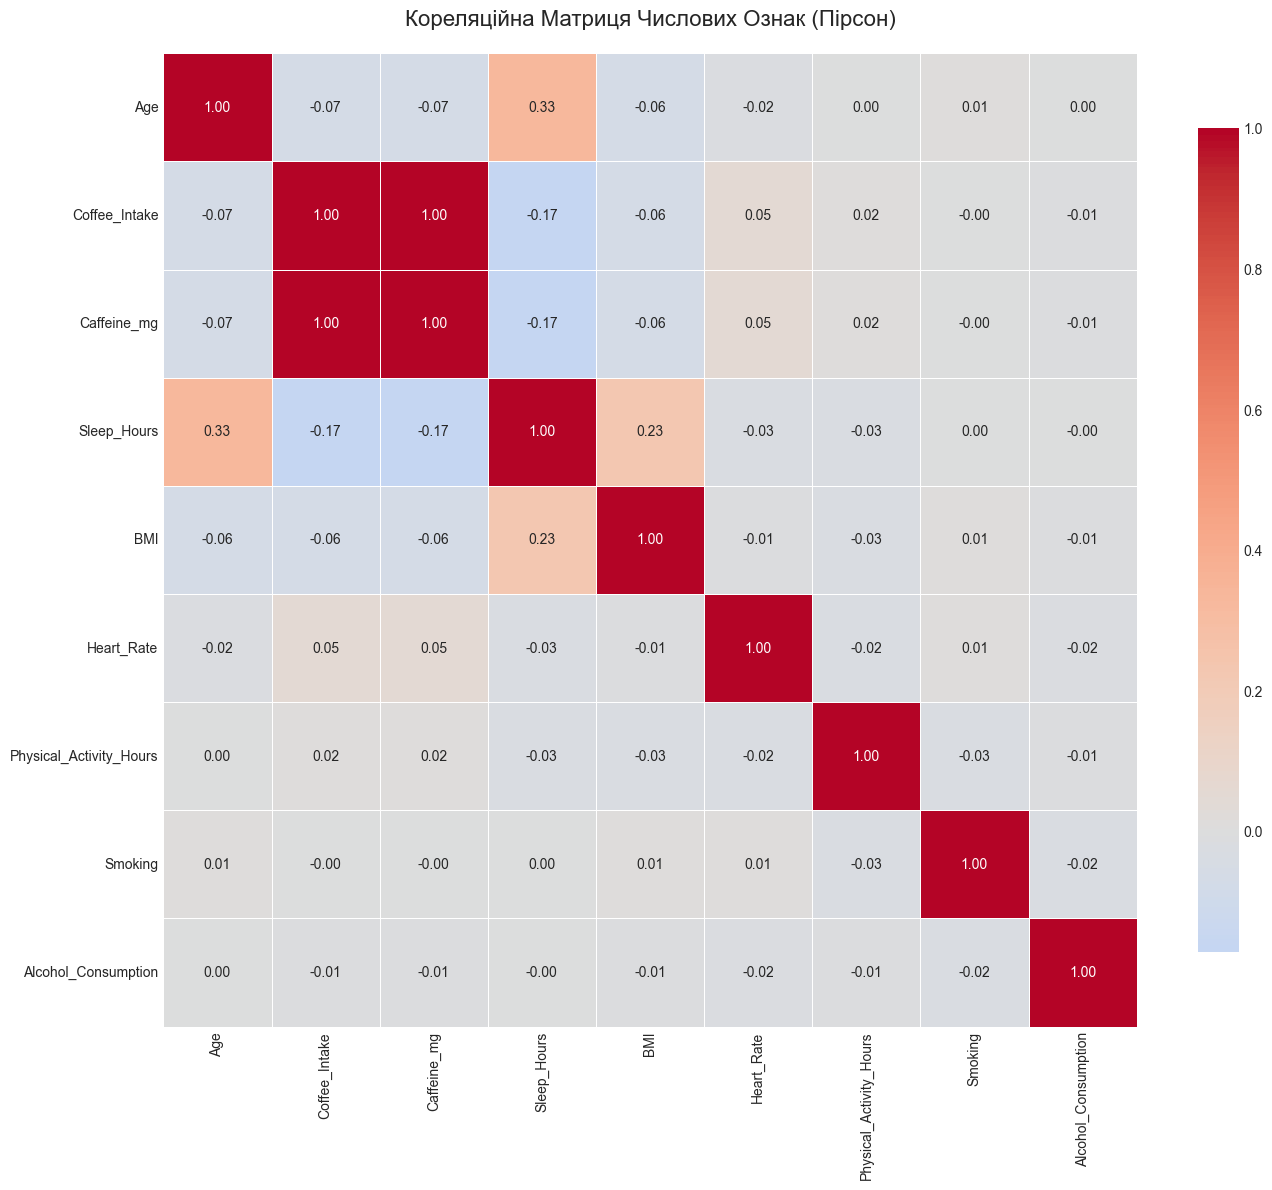


Пари ознак з |r| > 0.9:
  Coffee_Intake <-> Caffeine_mg: r = 1.000


In [30]:
print("\n" + "="*70)
print("КРОК 1: АНАЛІЗ КОРЕЛЯЦІЙ")
print("="*70)

# Відокремлення числових ознак
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Матриця кореляцій
correlation_matrix = df[numeric_cols].corr()

# Візуалізація
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Кореляційна Матриця Числових Ознак (Пірсон)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Пошук пар з високою кореляцією |r| > 0.9
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print(f"\nПари ознак з |r| > 0.9:")
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"  {pair[0]} <-> {pair[1]}: r = {pair[2]:.3f}")
else:
    print("  Не знайдено високо корельованих пар")

In [31]:
print("\n" + "="*70)
print("КРОК 2: ІНЖЕНЕРІЯ ОЗНАК")
print("="*70)

df_engineered = df.copy()

# 1. ВЗАЄМОДІЇ (Interactions)
print("\n1. Створення взаємодій:")
df_engineered['Coffee_Sleep_Interaction'] = (
    df_engineered['Coffee_Intake'] * df_engineered['Sleep_Hours']
)
print("   ✓ Coffee_Sleep_Interaction = Coffee_Intake × Sleep_Hours")

df_engineered['Caffeine_per_BMI'] = (
    df_engineered['Caffeine_mg'] / (df_engineered['BMI'] + 1)
)
print("   ✓ Caffeine_per_BMI = Caffeine_mg / (BMI + 1)")

df_engineered['Activity_Index'] = (
    df_engineered['Physical_Activity_Hours'] * df_engineered['Sleep_Hours']
)
print("   ✓ Activity_Index = Physical_Activity_Hours × Sleep_Hours")

df_engineered['Stress_Coffee_Interaction'] = pd.get_dummies(
    df_engineered['Stress_Level'], prefix='Stress'
).multiply(df_engineered['Coffee_Intake'], axis=0).sum(axis=1)
print("   ✓ Stress_Coffee_Interaction")

# 2. ПОЛІНОМІАЛЬНІ ОЗНАКИ
print("\n2. Поліноміальні ознаки:")
df_engineered['Coffee_Intake_Squared'] = df_engineered['Coffee_Intake'] ** 2
df_engineered['Age_Squared'] = df_engineered['Age'] ** 2
df_engineered['Caffeine_Squared'] = df_engineered['Caffeine_mg'] ** 2
print("   ✓ Coffee_Intake², Age², Caffeine_mg²")

# 3. БІНІНГ (Binning)
print("\n3. Категоризація неперервних змінних:")
df_engineered['Age_Binned'] = pd.cut(
    df_engineered['Age'], 
    bins=[18, 30, 50, 80], 
    labels=['Young', 'Middle', 'Old']
)
print("   ✓ Age_Binned: [18-30: Young, 30-50: Middle, 50-80: Old]")

df_engineered['Coffee_Level'] = pd.cut(
    df_engineered['Coffee_Intake'], 
    bins=[0, 2, 4, 10], 
    labels=['Low', 'Medium', 'High']
)
print("   ✓ Coffee_Level: [0-2: Low, 2-4: Medium, 4-10: High]")

df_engineered['BMI_Category'] = pd.cut(
    df_engineered['BMI'], 
    bins=[0, 18.5, 25, 30, 50],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)
print("   ✓ BMI_Category: [<18.5, 18.5-25, 25-30, >30]")

df_engineered['Sleep_Category'] = pd.cut(
    df_engineered['Sleep_Hours'],
    bins=[0, 6, 8, 12],
    labels=['Low', 'Normal', 'High']
)
print("   ✓ Sleep_Category: [<6: Low, 6-8: Normal, >8: High]")

# 4. СПІВВІДНОШЕННЯ
print("\n4. Співвідношення:")
df_engineered['Sleep_Coffee_Ratio'] = (
    df_engineered['Sleep_Hours'] / (df_engineered['Coffee_Intake'] + 0.1)
)
print("   ✓ Sleep_Coffee_Ratio = Sleep_Hours / (Coffee_Intake + 0.1)")

df_engineered['Activity_BMI_Ratio'] = (
    df_engineered['Physical_Activity_Hours'] / (df_engineered['BMI'] + 1)
)
print("   ✓ Activity_BMI_Ratio = Physical_Activity / (BMI + 1)")



КРОК 2: ІНЖЕНЕРІЯ ОЗНАК

1. Створення взаємодій:
   ✓ Coffee_Sleep_Interaction = Coffee_Intake × Sleep_Hours
   ✓ Caffeine_per_BMI = Caffeine_mg / (BMI + 1)
   ✓ Activity_Index = Physical_Activity_Hours × Sleep_Hours
   ✓ Stress_Coffee_Interaction

2. Поліноміальні ознаки:
   ✓ Coffee_Intake², Age², Caffeine_mg²

3. Категоризація неперервних змінних:
   ✓ Age_Binned: [18-30: Young, 30-50: Middle, 50-80: Old]
   ✓ Coffee_Level: [0-2: Low, 2-4: Medium, 4-10: High]
   ✓ BMI_Category: [<18.5, 18.5-25, 25-30, >30]
   ✓ Sleep_Category: [<6: Low, 6-8: Normal, >8: High]

4. Співвідношення:
   ✓ Sleep_Coffee_Ratio = Sleep_Hours / (Coffee_Intake + 0.1)
   ✓ Activity_BMI_Ratio = Physical_Activity / (BMI + 1)


In [32]:
print("\n" + "="*70)
print("КРОК 3: КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ")
print("="*70)

# Відокремлення цільової змінної
y = df_engineered['Health_Issues']
X = df_engineered.drop('Health_Issues', axis=1)

# Список всіх категоріальних колонок
categorical_cols = [
    'Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
    'Occupation', 'Smoking', 'Alcohol_Consumption',
    'Age_Binned', 'Coffee_Level', 'BMI_Category', 'Sleep_Category'
]

print(f"\nКатегоріальні змінні для кодування ({len(categorical_cols)}):")
for col in categorical_cols:
    if col in X.columns:
        print(f"  - {col}: {X[col].nunique()} унікальних значень")

# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\nДо кодування: {X.shape[1]} ознак")
print(f"Після кодування: {X_encoded.shape[1]} ознак")

# Label Encoding для цільової змінної
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nКласи Health_Issues:")
for cls, label in zip(le_target.classes_, range(len(le_target.classes_))):
    print(f"  {cls} -> {label}")


КРОК 3: КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ

Категоріальні змінні для кодування (11):
  - Gender: 3 унікальних значень
  - Country: 20 унікальних значень
  - Sleep_Quality: 4 унікальних значень
  - Stress_Level: 3 унікальних значень
  - Occupation: 5 унікальних значень
  - Smoking: 2 унікальних значень
  - Alcohol_Consumption: 2 унікальних значень
  - Age_Binned: 3 унікальних значень
  - Coffee_Level: 3 унікальних значень
  - BMI_Category: 4 унікальних значень
  - Sleep_Category: 3 унікальних значень

До кодування: 27 ознак
Після кодування: 57 ознак

Класи Health_Issues:
  Mild -> 0
  Moderate -> 1
  Severe -> 2


In [33]:
print("\n" + "="*70)
print("КРОК 4: НОРМАЛІЗАЦІЯ (Z-SCORE)")
print("="*70)

# Визначення числових колонок для нормалізації
numeric_features = [
    'Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 
    'BMI', 'Heart_Rate', 'Physical_Activity_Hours',
    'Coffee_Sleep_Interaction', 'Caffeine_per_BMI', 'Activity_Index',
    'Stress_Coffee_Interaction', 'Coffee_Intake_Squared', 'Age_Squared',
    'Caffeine_Squared', 'Sleep_Coffee_Ratio', 'Activity_BMI_Ratio'
]

# Вибір тільки тих, що існують
numeric_features = [col for col in numeric_features if col in X_encoded.columns]

print(f"Нормалізація {len(numeric_features)} числових ознак:")
for feat in numeric_features:
    print(f"  - {feat}")

# Стандартизація
scaler = StandardScaler()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])

print("\n✓ Нормалізація завершена")


КРОК 4: НОРМАЛІЗАЦІЯ (Z-SCORE)
Нормалізація 16 числових ознак:
  - Age
  - Coffee_Intake
  - Caffeine_mg
  - Sleep_Hours
  - BMI
  - Heart_Rate
  - Physical_Activity_Hours
  - Coffee_Sleep_Interaction
  - Caffeine_per_BMI
  - Activity_Index
  - Stress_Coffee_Interaction
  - Coffee_Intake_Squared
  - Age_Squared
  - Caffeine_Squared
  - Sleep_Coffee_Ratio
  - Activity_BMI_Ratio

✓ Нормалізація завершена


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("\n" + "="*70)
print("ПОДІЛ ДАНИХ")
print("="*70)
print(f"Тренувальна вибірка: {X_train.shape}")
print(f"Тестова вибірка: {X_test.shape}")



ПОДІЛ ДАНИХ
Тренувальна вибірка: (3247, 57)
Тестова вибірка: (812, 57)


In [35]:
print("\n" + "="*70)
print("КРОК 5: ОБЧИСЛЕННЯ FEATURE IMPORTANCE")
print("="*70)

# Припускаємо, що MyDecisionTree вже реалізований у попередніх пунктах
# Навчання моделі
my_tree_full = MyDecisionTree(max_depth=10, min_samples=5)
my_tree_full.fit(X_train.values, y_train)

# Прогноз
y_pred_full = my_tree_full.predict(X_test.values)

# Метрики на всіх ознаках
acc_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full, average='weighted')
mcc_full = matthews_corrcoef(y_test, y_pred_full)

print(f"\nMyDecisionTree на всіх {X_train.shape[1]} ознаках:")
print(f"  Accuracy:  {acc_full:.4f}")
print(f"  F1-score:  {f1_full:.4f}")
print(f"  MCC:       {mcc_full:.4f}")


КРОК 5: ОБЧИСЛЕННЯ FEATURE IMPORTANCE

MyDecisionTree на всіх 57 ознаках:
  Accuracy:  0.9951
  F1-score:  0.9950
  MCC:       0.9763



ТОП-20 НАЙВАЖЛИВІШИХ ОЗНАК
              Feature  Importance
     Stress_Level_Low    0.646515
                  BMI    0.231587
                  Age    0.121898
     Occupation_Other    0.000000
  Country_South Korea    0.000000
        Country_Spain    0.000000
       Country_Sweden    0.000000
  Country_Switzerland    0.000000
           Country_UK    0.000000
          Country_USA    0.000000
   Sleep_Quality_Fair    0.000000
   Sleep_Quality_Good    0.000000
   Sleep_Quality_Poor    0.000000
  Stress_Level_Medium    0.000000
    Occupation_Office    0.000000
   Occupation_Service    0.000000
  Country_Netherlands    0.000000
   Occupation_Student    0.000000
            Smoking_1    0.000000
Alcohol_Consumption_1    0.000000


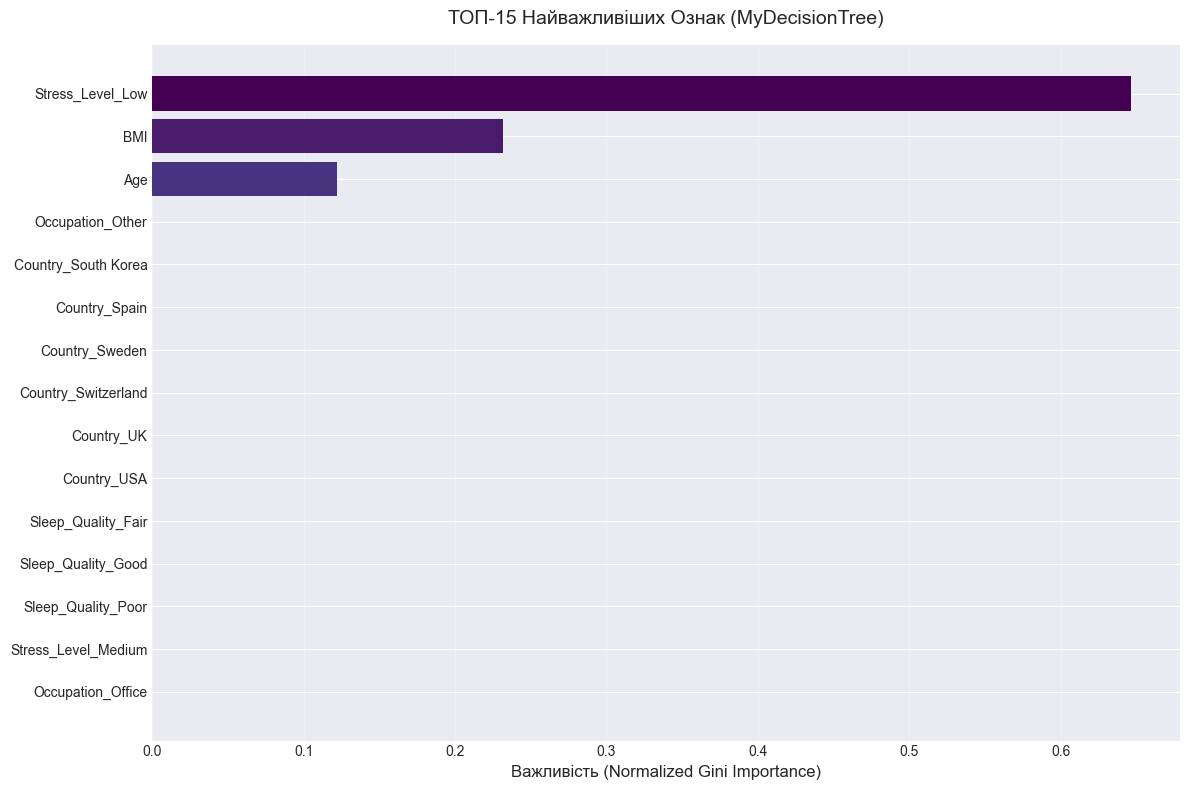

In [36]:
# Отримання важливості ознак
feature_names = X_encoded.columns.tolist()
importances = my_tree_full.feature_importance

# DataFrame для аналізу
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n" + "="*70)
print("ТОП-20 НАЙВАЖЛИВІШИХ ОЗНАК")
print("="*70)
print(importance_df.head(20).to_string(index=False))

# Візуалізація ТОП-15
plt.figure(figsize=(12, 8))
top_15 = importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))
plt.barh(range(len(top_15)), top_15['Importance'], color=colors)
plt.yticks(range(len(top_15)), top_15['Feature'], fontsize=10)
plt.xlabel('Важливість (Normalized Gini Importance)', fontsize=12)
plt.title('ТОП-15 Найважливіших Ознак (MyDecisionTree)', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [37]:
print("\n" + "="*70)
print("КРОК 6: FEATURE SELECTION")
print("="*70)

# Параметри відбору
K = 15  # Топ-15 ознак
threshold = 0.01  # Мінімальна важливість

# Метод 1: ТОП-K ознак за важливістю
top_k_indices = np.argsort(importances)[-K:][::-1]
selected_features = [feature_names[i] for i in top_k_indices]

print(f"\nВідібрано ТОП-{K} ознак за Gini importance:")
for i, feat in enumerate(selected_features, 1):
    imp = importances[feature_names.index(feat)]
    print(f"{i:2d}. {feat:40s} (importance: {imp:.4f})")

# Метод 2: За порогом
selected_by_threshold = importance_df[
    importance_df['Importance'] > threshold
]['Feature'].tolist()

print(f"\nОзнак з важливістю > {threshold}: {len(selected_by_threshold)}")

# Створення датасетів з відібраними ознаками
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nРозмірність після відбору:")
print(f"  Було:   {X_train.shape[1]} ознак")
print(f"  Стало:  {X_train_selected.shape[1]} ознак")
print(f"  Зменшення: {X_train.shape[1] - X_train_selected.shape[1]} ознак")



КРОК 6: FEATURE SELECTION

Відібрано ТОП-15 ознак за Gini importance:
 1. Stress_Level_Low                         (importance: 0.6465)
 2. BMI                                      (importance: 0.2316)
 3. Age                                      (importance: 0.1219)
 4. Sleep_Coffee_Ratio                       (importance: 0.0000)
 5. Country_India                            (importance: 0.0000)
 6. Country_Germany                          (importance: 0.0000)
 7. Country_France                           (importance: 0.0000)
 8. Country_Finland                          (importance: 0.0000)
 9. Country_China                            (importance: 0.0000)
10. Country_Canada                           (importance: 0.0000)
11. Country_Brazil                           (importance: 0.0000)
12. Country_Belgium                          (importance: 0.0000)
13. Gender_Other                             (importance: 0.0000)
14. Gender_Male                              (importance: 0.0000)
15. A

In [38]:
print("\n" + "="*70)
print("КРОК 7: НАВЧАННЯ НА ВІДІБРАНИХ ОЗНАКАХ")
print("="*70)

# MyDecisionTree на відібраних ознаках
my_tree_selected = MyDecisionTree(max_depth=10, min_samples=5)
my_tree_selected.fit(X_train_selected.values, y_train)
y_pred_selected = my_tree_selected.predict(X_test_selected.values)

acc_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected, average='weighted')
mcc_selected = matthews_corrcoef(y_test, y_pred_selected)

print(f"\n1. MyDecisionTree (відібрані {K} ознак):")
print(f"   Accuracy:  {acc_selected:.4f}  (Δ = {acc_selected - acc_full:+.4f})")
print(f"   F1-score:  {f1_selected:.4f}  (Δ = {f1_selected - f1_full:+.4f})")
print(f"   MCC:       {mcc_selected:.4f}  (Δ = {mcc_selected - mcc_full:+.4f})")

# sklearn DecisionTree
from sklearn.tree import DecisionTreeClassifier
dt_selected = DecisionTreeClassifier(
    criterion='gini', max_depth=10, min_samples_leaf=5, random_state=42
)
dt_selected.fit(X_train_selected, y_train)
y_pred_dt = dt_selected.predict(X_test_selected)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

print(f"\n2. sklearn DecisionTree (відібрані {K} ознак):")
print(f"   Accuracy:  {acc_dt:.4f}")
print(f"   F1-score:  {f1_dt:.4f}")
print(f"   MCC:       {mcc_dt:.4f}")

# RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_selected = RandomForestClassifier(
    n_estimators=100, criterion='gini', max_depth=10, random_state=42, n_jobs=-1
)
rf_selected.fit(X_train_selected, y_train)
y_pred_rf = rf_selected.predict(X_test_selected)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print(f"\n3. RandomForest (відібрані {K} ознак):")
print(f"   Accuracy:  {acc_rf:.4f}")
print(f"   F1-score:  {f1_rf:.4f}")
print(f"   MCC:       {mcc_rf:.4f}")



КРОК 7: НАВЧАННЯ НА ВІДІБРАНИХ ОЗНАКАХ



1. MyDecisionTree (відібрані 15 ознак):
   Accuracy:  0.9951  (Δ = +0.0000)
   F1-score:  0.9950  (Δ = +0.0000)
   MCC:       0.9763  (Δ = +0.0000)

2. sklearn DecisionTree (відібрані 15 ознак):
   Accuracy:  0.9938
   F1-score:  0.9938
   MCC:       0.9703

3. RandomForest (відібрані 15 ознак):
   Accuracy:  0.9938
   F1-score:  0.9937
   MCC:       0.9703



КРОК 8: PERMUTATION IMPORTANCE

ТОП-15 ознак за Permutation Importance:
            Feature  Perm_Importance_Mean  Perm_Importance_Std
                Age              0.226232             0.010751
   Stress_Level_Low              0.207020             0.010572
                BMI              0.161823             0.005988
   Occupation_Other              0.000000             0.000000
Country_South Korea              0.000000             0.000000
      Country_Spain              0.000000             0.000000
     Country_Sweden              0.000000             0.000000
Country_Switzerland              0.000000             0.000000
         Country_UK              0.000000             0.000000
        Country_USA              0.000000             0.000000
 Sleep_Quality_Fair              0.000000             0.000000
 Sleep_Quality_Good              0.000000             0.000000
 Sleep_Quality_Poor              0.000000             0.000000
Stress_Level_Medium              0.000000    

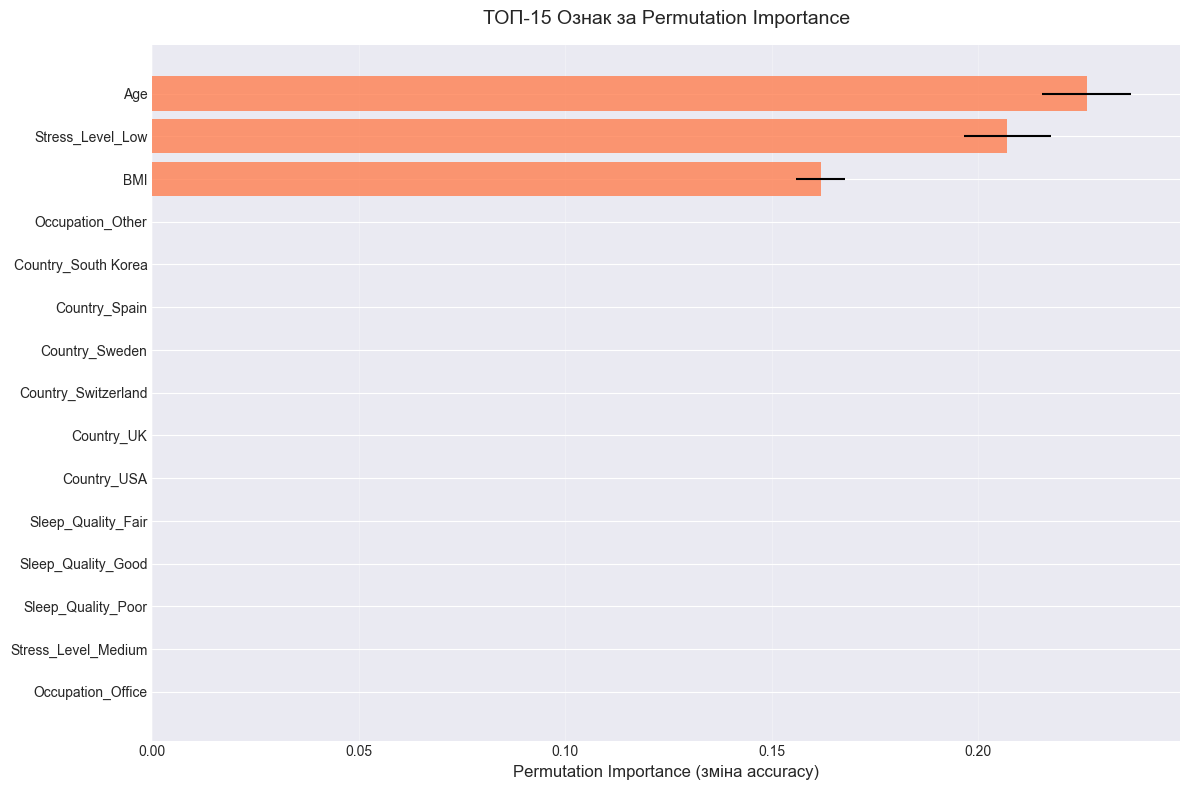

In [39]:
print("\n" + "="*70)
print("КРОК 8: PERMUTATION IMPORTANCE")
print("="*70)

# Обчислення permutation importance для MyDecisionTree
perm_imp_result = permutation_importance(
    my_tree_full, X_test.values, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

# DataFrame з результатами
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Perm_Importance_Mean': perm_imp_result.importances_mean,
    'Perm_Importance_Std': perm_imp_result.importances_std
}).sort_values('Perm_Importance_Mean', ascending=False)

print("\nТОП-15 ознак за Permutation Importance:")
print(perm_df.head(15).to_string(index=False))

# Візуалізація
plt.figure(figsize=(12, 8))
top_15_perm = perm_df.head(15)
plt.barh(range(len(top_15_perm)), top_15_perm['Perm_Importance_Mean'],
         xerr=top_15_perm['Perm_Importance_Std'], color='coral', alpha=0.8)
plt.yticks(range(len(top_15_perm)), top_15_perm['Feature'], fontsize=10)
plt.xlabel('Permutation Importance (зміна accuracy)', fontsize=12)
plt.title('ТОП-15 Ознак за Permutation Importance', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


ПОРІВНЯННЯ МЕТОДІВ ОЦІНКИ ВАЖЛИВОСТІ

Порівняння методів для відібраних ознак:
           Feature  Gini_Importance  Permutation_Importance  RandomForest_Importance
  Stress_Level_Low         0.646515                0.347889                 0.305881
               BMI         0.231587                0.271937                 0.243007
               Age         0.121898                0.380174                 0.317714
Sleep_Coffee_Ratio         0.000000                0.000000                 0.068929
     Country_India         0.000000                0.000000                 0.001415
   Country_Germany         0.000000                0.000000                 0.001992
    Country_France         0.000000                0.000000                 0.001410
   Country_Finland         0.000000                0.000000                 0.002915
     Country_China         0.000000                0.000000                 0.001817
    Country_Canada         0.000000                0.000000           

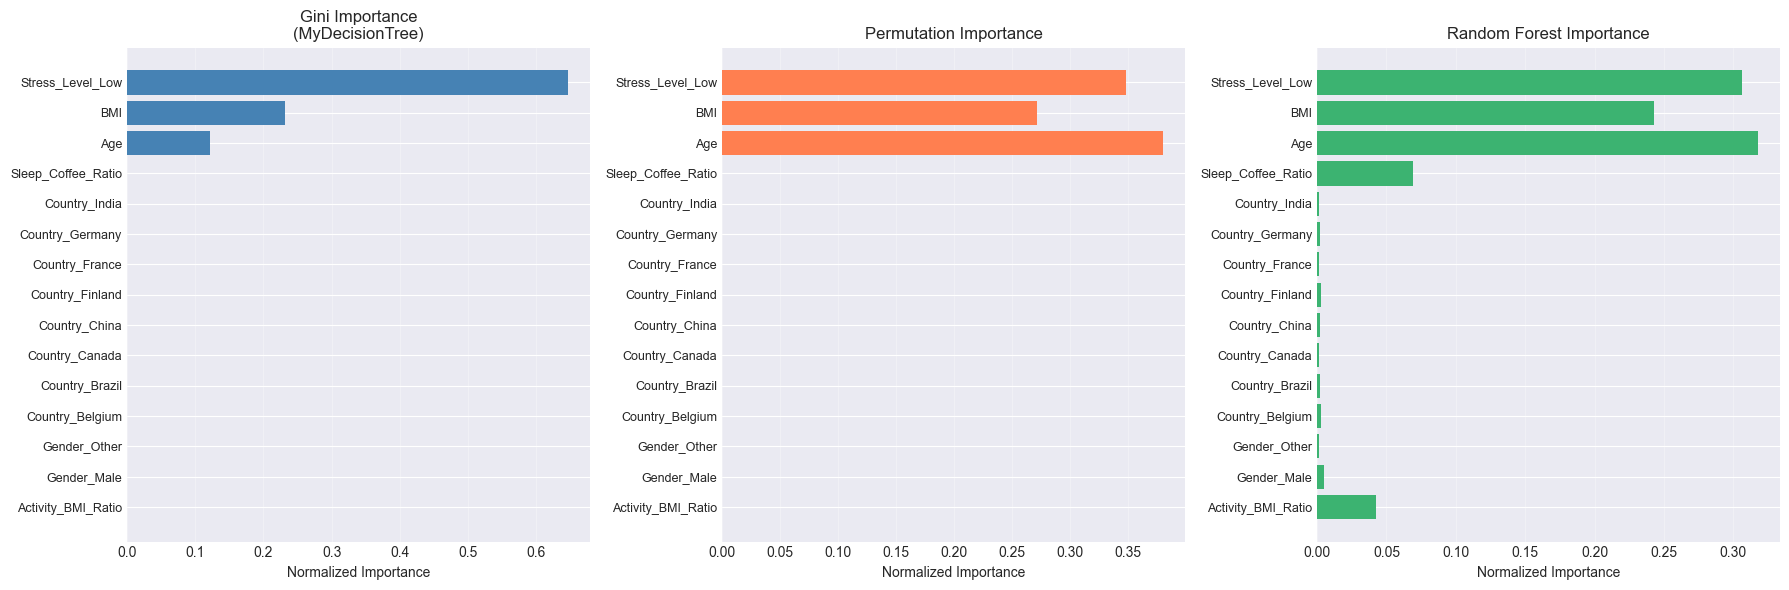

In [40]:
print("\n" + "="*70)
print("ПОРІВНЯННЯ МЕТОДІВ ОЦІНКИ ВАЖЛИВОСТІ")
print("="*70)

# Для відібраних ознак порівняємо 3 методи
comparison_features = selected_features

# Збір важливостей
gini_imp = [importances[feature_names.index(f)] for f in comparison_features]
perm_imp = [perm_df[perm_df['Feature']==f]['Perm_Importance_Mean'].values[0] 
            for f in comparison_features]
rf_imp = [rf_selected.feature_importances_[i] 
          for i in range(len(selected_features))]

# Нормалізація
gini_norm = np.array(gini_imp) / np.sum(gini_imp)
perm_norm = np.array(perm_imp) / (np.sum(np.abs(perm_imp)) + 1e-10)
rf_norm = np.array(rf_imp) / np.sum(rf_imp)

# Порівняльна таблиця
comparison_df = pd.DataFrame({
    'Feature': comparison_features,
    'Gini_Importance': gini_norm,
    'Permutation_Importance': perm_norm,
    'RandomForest_Importance': rf_norm
}).sort_values('Gini_Importance', ascending=False)

print("\nПорівняння методів для відібраних ознак:")
print(comparison_df.to_string(index=False))

# Візуалізація порівняння
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].barh(range(len(comparison_features)), gini_norm, color='steelblue')
axes[0].set_yticks(range(len(comparison_features)))
axes[0].set_yticklabels(comparison_features, fontsize=9)
axes[0].set_xlabel('Normalized Importance')
axes[0].set_title('Gini Importance\n(MyDecisionTree)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(range(len(comparison_features)), perm_norm, color='coral')
axes[1].set_yticks(range(len(comparison_features)))
axes[1].set_yticklabels(comparison_features, fontsize=9)
axes[1].set_xlabel('Normalized Importance')
axes[1].set_title('Permutation Importance')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

axes[2].barh(range(len(comparison_features)), rf_norm, color='mediumseagreen')
axes[2].set_yticks(range(len(comparison_features)))
axes[2].set_yticklabels(comparison_features, fontsize=9)
axes[2].set_xlabel('Normalized Importance')
axes[2].set_title('Random Forest Importance')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



КРОК 9: КРОС-ВАЛІДАЦІЯ (5-FOLD)

sklearn DecisionTree:
  CV Scores: [1.         0.99846154 0.99845917 0.99691834 0.9953775 ]
  Mean:      0.9978
  Std:       0.0016
  95% CI:    0.9978 ± 0.0031

RandomForest:
  CV Scores: [1.         0.99846154 0.9953775  0.99229584 0.99383667]
  Mean:      0.9960
  Std:       0.0029
  95% CI:    0.9960 ± 0.0056


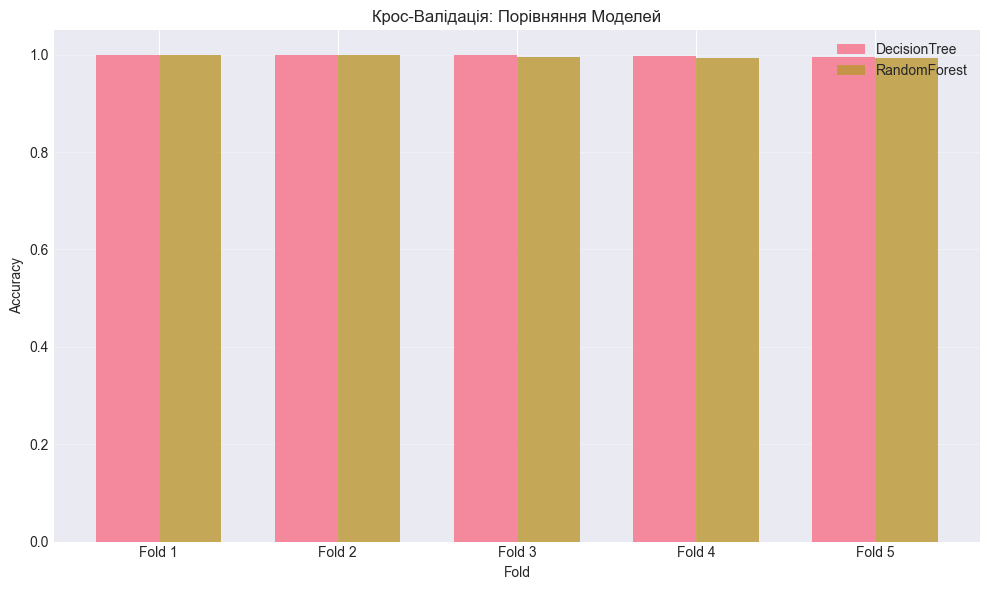

In [41]:
print("\n" + "="*70)
print("КРОК 9: КРОС-ВАЛІДАЦІЯ (5-FOLD)")
print("="*70)

# sklearn DecisionTree
cv_dt = cross_val_score(dt_selected, X_train_selected, y_train, 
                        cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nsklearn DecisionTree:")
print(f"  CV Scores: {cv_dt}")
print(f"  Mean:      {cv_dt.mean():.4f}")
print(f"  Std:       {cv_dt.std():.4f}")
print(f"  95% CI:    {cv_dt.mean():.4f} ± {1.96*cv_dt.std():.4f}")

# RandomForest
cv_rf = cross_val_score(rf_selected, X_train_selected, y_train, 
                        cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nRandomForest:")
print(f"  CV Scores: {cv_rf}")
print(f"  Mean:      {cv_rf.mean():.4f}")
print(f"  Std:       {cv_rf.std():.4f}")
print(f"  95% CI:    {cv_rf.mean():.4f} ± {1.96*cv_rf.std():.4f}")

# Візуалізація CV scores
plt.figure(figsize=(10, 6))
x = np.arange(5)
width = 0.35
plt.bar(x - width/2, cv_dt, width, label='DecisionTree', alpha=0.8)
plt.bar(x + width/2, cv_rf, width, label='RandomForest', alpha=0.8)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Крос-Валідація: Порівняння Моделей')
plt.xticks(x, [f'Fold {i+1}' for i in range(5)])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



ФІНАЛЬНЕ ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ

                    Модель  Кількість_ознак  Accuracy  F1-Score      MCC   CV_Mean
      MyDecisionTree (всі)               57  0.995074  0.995027 0.976319         -
MyDecisionTree (відібрані)               15  0.995074  0.995027 0.976319         -
    sklearn DT (відібрані)               15  0.993842  0.993768 0.970350  0.997843
  RandomForest (відібрані)               15  0.993842  0.993676 0.970297  0.995994


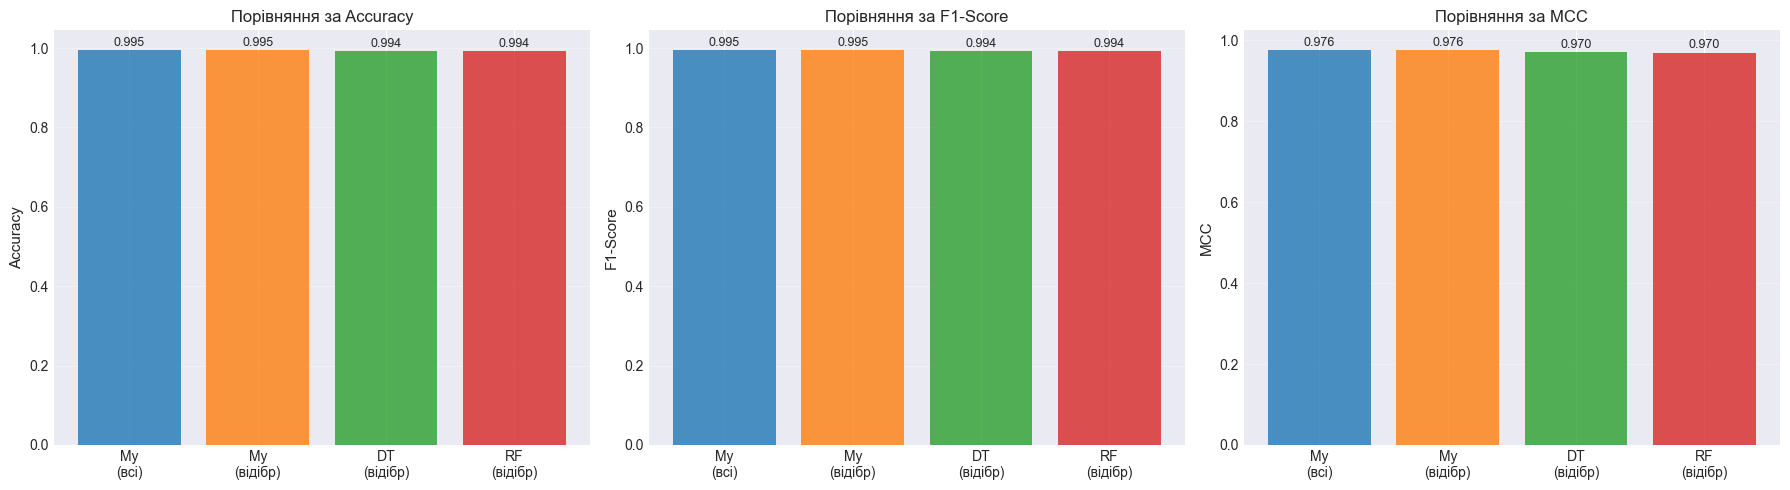

In [42]:
print("\n" + "="*70)
print("ФІНАЛЬНЕ ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ")
print("="*70)

results = pd.DataFrame({
    'Модель': [
        'MyDecisionTree (всі)',
        'MyDecisionTree (відібрані)',
        'sklearn DT (відібрані)',
        'RandomForest (відібрані)'
    ],
    'Кількість_ознак': [
        X_train.shape[1],
        X_train_selected.shape[1],
        X_train_selected.shape[1],
        X_train_selected.shape[1]
    ],
    'Accuracy': [acc_full, acc_selected, acc_dt, acc_rf],
    'F1-Score': [f1_full, f1_selected, f1_dt, f1_rf],
    'MCC': [mcc_full, mcc_selected, mcc_dt, mcc_rf],
    'CV_Mean': ['-', '-', cv_dt.mean(), cv_rf.mean()]
})

print("\n" + results.to_string(index=False))

# Візуалізація порівняння
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['Accuracy', 'F1-Score', 'MCC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics):
    axes[idx].bar(range(len(results)), results[metric], color=colors, alpha=0.8)
    axes[idx].set_xticks(range(len(results)))
    axes[idx].set_xticklabels(['My\n(всі)', 'My\n(відібр)', 'DT\n(відібр)', 'RF\n(відібр)'])
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].set_title(f'Порівняння за {metric}', fontsize=12)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Додавання значень на графік
    for i, v in enumerate(results[metric]):
        if v != '-':
            axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [43]:
print("\n" + "="*70)
print("ВИСНОВКИ ТА АНАЛІЗ")
print("="*70)

print("\n📊 1. ІНЖЕНЕРІЯ ОЗНАК:")
print(f"   • Початкова кількість: {df.shape[1] - 1} ознак")
print(f"   • Після інженерії: {X_encoded.shape[1]} ознак")
print(f"   • Створено нових: {X_encoded.shape[1] - (df.shape[1] - 1)} ознак")
print("   • Типи створених ознак:")
print("     - Взаємодії (interactions)")
print("     - Поліноміальні ознаки")
print("     - Бінінг (категоризація)")
print("     - Співвідношення")

print("\n🎯 2. FEATURE SELECTION:")
print(f"   • Відібрано: {K} найважливіших ознак")
print(f"   • Зменшення розмірності: {X_encoded.shape[1]} -> {K}")
print(f"   • Вплив на MyDecisionTree accuracy: {acc_selected - acc_full:+.4f}")
print(f"   • Зменшення шуму через відбір релевантних ознак")

print("\n📈 3. ПОРІВНЯННЯ МОДЕЛЕЙ:")
print(f"   • MyDecisionTree (всі): Acc={acc_full:.4f}, F1={f1_full:.4f}")
print(f"   • MyDecisionTree (відібрані): Acc={acc_selected:.4f}, F1={f1_selected:.4f}")
print(f"   • sklearn DT (відібрані): Acc={acc_dt:.4f}, F1={f1_dt:.4f}")
print(f"   • RandomForest (відібрані): Acc={acc_rf:.4f}, F1={f1_rf:.4f}")
print(f"   • Найкраща модель: RandomForest з accuracy={acc_rf:.4f}")

print("\n🔍 4. МЕТОДИ ОЦІНКИ ВАЖЛИВОСТІ:")
print("   • Gini Importance:")
print("     - Базується на зменшенні Gini impurity")
print("     - Швидко обчислюється під час побудови дерева")
print("     - Може бути зміщеною для категоріальних ознак")
print("   • Permutation Importance:")
print("     - Оцінює реальний вплив на performance")
print("     - Більш надійна, але повільніша")
print("     - Враховує взаємодії між ознаками")
print("   • RandomForest Importance:")
print("     - Усереднена важливість по багатьох деревах")
print("     - Більш стабільна через averaging")
print("     - Зменшує variance окремого дерева")

print("\n✅ 5. ЕФЕКТ ІНЖЕНЕРІЇ ТА SELECTION:")
change_acc = acc_selected - acc_full
change_f1 = f1_selected - f1_full
if change_acc >= 0:
    print(f"   • Accuracy покращилась на {change_acc:.4f}")
else:
    print(f"   • Accuracy зменшилась на {abs(change_acc):.4f} (через зменшення overfitting)")
print(f"   • Зменшення кількості ознак у {X_encoded.shape[1]/K:.1f} разів")
print(f"   • RandomForest показує найкращі результати завдяки:")
print("     - Averaging багатьох дерев (зменшення variance)")
print("     - Random feature selection (decorrelation)")
print("     - Bootstrapping (robustness)")

print("\n💡 6. НАЙВАЖЛИВІШІ ОЗНАКИ:")
top_5_features = importance_df.head(5)
print("   Топ-5 за Gini importance:")
for i, row in enumerate(top_5_features.itertuples(), 1):
    print(f"   {i}. {row.Feature}: {row.Importance:.4f}")


ВИСНОВКИ ТА АНАЛІЗ

📊 1. ІНЖЕНЕРІЯ ОЗНАК:
   • Початкова кількість: 14 ознак
   • Після інженерії: 57 ознак
   • Створено нових: 43 ознак
   • Типи створених ознак:
     - Взаємодії (interactions)
     - Поліноміальні ознаки
     - Бінінг (категоризація)
     - Співвідношення

🎯 2. FEATURE SELECTION:
   • Відібрано: 15 найважливіших ознак
   • Зменшення розмірності: 57 -> 15
   • Вплив на MyDecisionTree accuracy: +0.0000
   • Зменшення шуму через відбір релевантних ознак

📈 3. ПОРІВНЯННЯ МОДЕЛЕЙ:
   • MyDecisionTree (всі): Acc=0.9951, F1=0.9950
   • MyDecisionTree (відібрані): Acc=0.9951, F1=0.9950
   • sklearn DT (відібрані): Acc=0.9938, F1=0.9938
   • RandomForest (відібрані): Acc=0.9938, F1=0.9937
   • Найкраща модель: RandomForest з accuracy=0.9938

🔍 4. МЕТОДИ ОЦІНКИ ВАЖЛИВОСТІ:
   • Gini Importance:
     - Базується на зменшенні Gini impurity
     - Швидко обчислюється під час побудови дерева
     - Може бути зміщеною для категоріальних ознак
   • Permutation Importance:
     - 